# Notebook to compare isaura and esmeralda output to see where/if satellite are real and where they come from

But also to check if the Z values are identical

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

from concurrent.futures import ProcessPoolExecutor

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io           import load_dst, load_dsts, df_writer
from invisible_cities.io.hits_io          import hits_writer
from invisible_cities.core                import tbl_functions   as tbl
from invisible_cities.core.core_functions import in_range
from invisible_cities.cities.beersheba    import hitc_to_df_
from invisible_cities.io.hits_io          import hits_from_df
from invisible_cities.evm.nh5             import HitsTable
from invisible_cities.types.symbols       import NormStrategy
from invisible_cities.types.ic_types      import NoneType
from invisible_cities.reco.corrections    import read_maps, get_df_to_z_converter, apply_all_correction
from invisible_cities.evm.event_model     import HitCollection


from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType
from IC.invisible_cities.cities                 import beersheba as beerfun

import IC.invisible_cities.core.core_functions                   as     coref

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod


from tqdm import tqdm

import functions_HE as func


In [2]:
def load_single_file(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /Tracking/Tracks

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /Tracking/Tracks data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'Tracking', 'Tracks')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x

def load_file_hits(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /DECO/Events

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /DECO/Events data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'DECO', 'Events')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x
    
    

def load_file_soph_hits(file_path):
    '''
    Load data from a single h5 file and produce dataframes for /RECO/Events

    Args:
        file_path       :       str
                                Path to the h5 file to be loaded.

    Returns:
        tracks_df       :       pandas.DataFrame
                                DataFrame containing the /RECO/Events data.
    '''
    try: 
        tracks_df = load_dst(file_path, 'RECO', 'Events')
        return tracks_df
    except Exception as e:
        print(f'File {file_path} broke with error:\n{e}')
        x = pd.DataFrame()
        return x
    

def load_data_fast(folder_path, func):
    '''
    Load multiple h5 files and produce concatenated dataframes for /Tracking/Tracks, /MC/Particles, and their corresponding eventmap.

    Args:
        folder_path     :       str
                                Path to the folder containing the h5 files.
        func            :       function
                                The function you're passing that defines the df you're retrieving

    Returns:
        tracks          :       pandas.DataFrame
                                Concatenated DataFrame containing the /Tracking/Tracks data from all h5 files.
        
        particles       :       pandas.DataFrame
                                Concatenated DataFrame containing the /MC/particles data from all h5 files, with the 'event_id' column modified.

        eventmap        :       pandas.DataFrame
                                Concatenated DataFrame containing the event map from all h5 files.
    '''
    
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
    file_paths = [os.path.join(folder_path, f) for f in file_names]

    # Use ProcessPoolExecutor to parallelize the data loading process
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(func, file_paths))
    
    # Separate the results into respective lists
    tracks_list = results

    # Concatenate all the dataframes at once
    tracks = pd.concat(tracks_list, axis=0, ignore_index=True)

    return tracks

In [3]:
RUN_NUMBER      = '15107'
TIMESTAMP_ISAU  = '240425'
TIMESTAMP_ESME  = '070525'

In [4]:
# Load in all isaura data from LDC 1
n100_dir = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/isaura/{TIMESTAMP_ISAU}/'
i = 1
hdst = []

folder_path = n100_dir + 'ldc' + str(i) + '/'
hdst.append(load_data_fast(folder_path, load_single_file))

hdst = pd.concat(hdst)

File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/isaura/240425/ldc1/isaura_run_15107_0676_ldc1_240425.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/isaura/240425/ldc1/isaura_run_15107_0876_ldc1_240425.h5 broke with error:
group ``/`` does not have a child named ``Tracking``


In [5]:
# Load in all isaura data from LDC 1
n100_dir = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/esmeralda/{TIMESTAMP_ESME}/'
i = 1
esme_hdst = []

folder_path = n100_dir + 'ldc' + str(i) + '/'
esme_hdst.append(load_data_fast(folder_path, load_single_file))

esme_hdst = pd.concat(esme_hdst)

File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/esmeralda/070525/ldc1/run_15107_0676_ldc1.h5 broke with error:
group ``/`` does not have a child named ``Tracking``
File /gluster/data/next/files/TOPOLOGY_John/N100_data/15107/esmeralda/070525/ldc1/run_15107_0876_ldc1.h5 broke with error:
group ``/`` does not have a child named ``Tracking``


In [6]:
# load in the sophronia hits 
soph_hits = []
n100_dir_soph = f'/gluster/data/next/files/TOPOLOGY_John/N100_data/{RUN_NUMBER}/sophronia_rebin/trigger_2/'



folder_path = n100_dir_soph + 'ldc1' + '/'
soph_hits.append(load_data_fast(folder_path, load_file_soph_hits))

soph_hits = pd.concat(soph_hits)

In [7]:
display(hdst)
display(esme_hdst)
display(soph_hits)

#print(sorted(hdst.event.unique()))
#print(sorted(esme_hdst.event.unique()))
#print(sorted(soph_hits.event.unique()))

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,8948,0,0.627782,98.488994,91,1584,2,-176.375,273.825,1372.330129,...,1380.533915,-144.312554,321.944293,1457.465196,0.246330,0.168424,0.000000,11.951220,11.802326,11.361525
1,8948,1,0.128133,27.851397,7,215,2,278.625,-168.675,1440.893132,...,1447.827128,294.496045,-150.151347,1466.777666,0.126592,0.124770,0.123228,11.951220,11.802326,11.361525
2,9053,0,0.694676,81.799334,82,1627,3,208.625,316.325,1098.644016,...,1167.480315,220.980848,344.323564,1098.644016,0.160748,0.083288,0.000000,11.904762,11.875000,11.998640
3,9053,1,0.163198,35.995919,14,411,3,-223.875,-96.175,1864.630107,...,1898.521110,-205.877463,-81.943843,1864.630107,0.120636,0.114544,0.071981,11.904762,11.875000,11.998640
4,9053,2,0.042026,11.998640,2,67,3,-211.375,-41.175,-289.029569,...,-283.708164,-203.872606,-40.184434,-272.790899,0.042026,0.042026,0.042026,11.904762,11.875000,11.998640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43895,2328146,0,1.185483,375.270338,294,4274,1,271.125,111.325,1088.430908,...,1243.386955,277.988287,259.152533,1119.829331,0.121186,0.055174,0.000000,11.833333,11.785714,11.470197
43896,2328160,0,1.205236,285.692007,224,3460,2,-6.375,-216.175,944.113549,...,1160.574744,47.082483,-212.790341,1006.732518,0.151767,0.046212,0.000000,11.428571,12.000000,11.818591
43897,2328160,1,0.046350,28.661366,7,83,2,41.125,-216.175,1039.574306,...,1044.673824,45.795528,-197.803861,1069.385690,0.039458,0.033603,0.026711,11.428571,12.000000,11.818591
43898,2328174,0,0.604950,88.596829,100,1816,2,-41.375,-316.175,1605.504274,...,1612.905621,-22.993630,-297.393510,1691.989391,0.182238,0.129919,0.000000,11.500000,11.250000,11.996438


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,10166,0,0.415210,63.471722,33,86,1,196.575,338.225,1781.092665,...,1801.073709,196.575,370.743177,1815.518943,0.146817,0.064273,0.000000,15.383333,15.407143,14.782316
1,10453,0,0.740262,103.442673,95,187,9,73.175,276.025,2233.446846,...,2270.714384,149.925,291.575000,2292.235920,0.099251,0.070709,0.000000,16.827273,16.771739,16.980909
2,10453,1,0.365148,74.073339,34,90,9,149.925,-31.975,-76.877316,...,-48.754585,181.025,-16.987635,-49.781622,0.071582,0.065019,0.000000,16.827273,16.771739,16.980909
3,10453,2,0.329686,74.239940,35,86,9,88.725,152.625,2953.384075,...,2976.296567,149.925,166.014442,2973.909088,0.077542,0.071933,0.000000,16.827273,16.771739,16.980909
4,10453,3,0.209372,57.301600,18,38,9,88.725,152.625,2831.495742,...,2850.245663,119.825,214.825000,2850.555823,0.097981,0.067562,0.000000,16.827273,16.771739,16.980909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49324,2327586,1,0.000782,0.000000,1,1,2,57.625,477.175,588.891717,...,588.891717,57.625,477.175000,588.891717,0.000782,0.000782,0.000782,15.550000,15.425000,16.772549
49325,2327712,0,0.459605,65.316483,36,103,1,319.975,184.225,1893.441476,...,1929.057324,319.975,197.843675,1929.766595,0.091792,0.076571,0.000000,15.383333,15.407143,15.383975
49326,2328146,0,1.185483,316.588984,298,512,1,257.775,90.925,1088.430908,...,1232.065939,288.875,278.452336,1141.213575,0.094044,0.044332,0.000000,16.762500,16.762500,16.336187
49327,2328160,0,1.251586,263.459122,283,516,1,-34.675,-233.125,944.113549,...,1148.534681,57.625,-202.025000,997.208353,0.073459,0.042639,0.000000,15.425000,16.762500,16.633522


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2285152,1.742964e+09,0,5.905803,14.673545,1,-373.775,-124.775,0.0,0.0,-1052.52606,5.326621,0.705017,-1.0,0.000002,-1,-1.0
1,2285152,1.742964e+09,0,5.905803,14.673545,1,-235.825,353.775,0.0,0.0,-1052.52606,6.437058,0.851991,-1.0,0.000002,-1,-1.0
2,2285152,1.742964e+09,0,5.905803,14.673545,1,-126.975,492.725,0.0,0.0,-1052.52606,7.872653,1.042002,-1.0,NaN,-1,-1.0
3,2285152,1.742964e+09,0,5.905803,14.673545,1,-3.575,-247.675,0.0,0.0,-1052.52606,8.136606,1.076938,-1.0,0.000003,-1,-1.0
4,2285152,1.742964e+09,0,5.905803,14.673545,1,149.925,-155.375,0.0,0.0,-1052.52606,7.138769,0.944867,-1.0,0.000002,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30631619,1680506,1.742957e+09,51,18.424122,31.003202,1,-420.425,75.375,0.0,0.0,1627.68450,6.089463,-0.660906,-1.0,-0.000002,-1,-1.0
30631620,1680506,1.742957e+09,51,18.424122,31.003202,1,-235.825,430.525,0.0,0.0,1627.68450,6.411536,-0.695861,-1.0,NaN,-1,-1.0
30631621,1680506,1.742957e+09,51,18.424122,31.003202,1,10.975,291.575,0.0,0.0,1627.68450,6.349580,-0.689137,-1.0,-0.000002,-1,-1.0
30631622,1680506,1.742957e+09,51,18.424122,31.003202,1,227.675,414.975,0.0,0.0,1627.68450,5.055957,-0.548736,-1.0,NaN,-1,-1.0


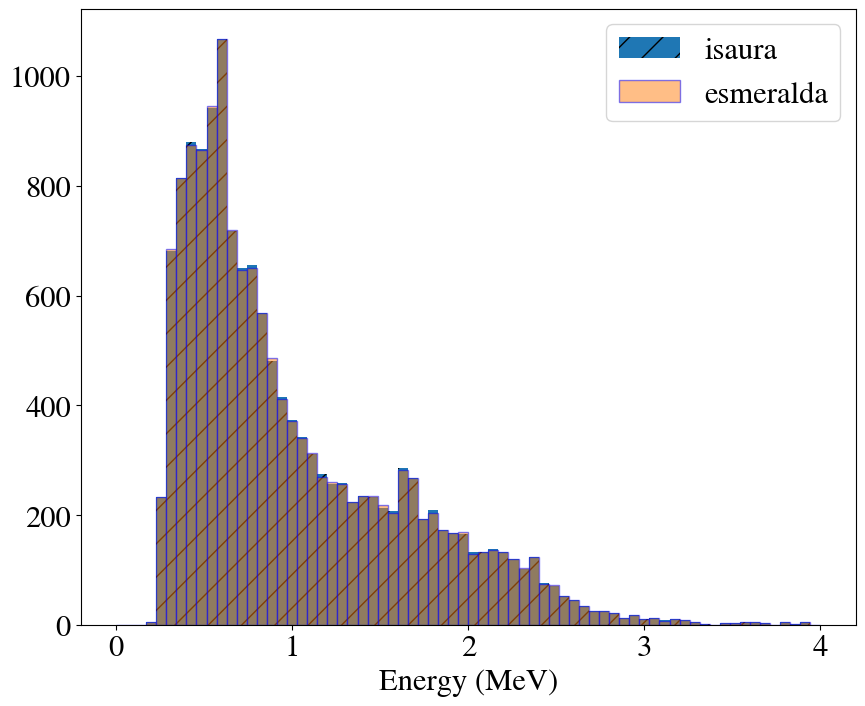

In [8]:
range_bins = (0, 4)

plt.hist(hdst.groupby('event').energy.sum(), bins = 70, label = 'isaura', hatch = '/', range = range_bins)
plt.hist(esme_hdst.groupby('event').energy.sum(), bins = 70, label = 'esmeralda', alpha = 0.5, edgecolor = 'b', range = range_bins)
plt.legend()
plt.xlabel('Energy (MeV)')
plt.show()

## plot Z parameters 

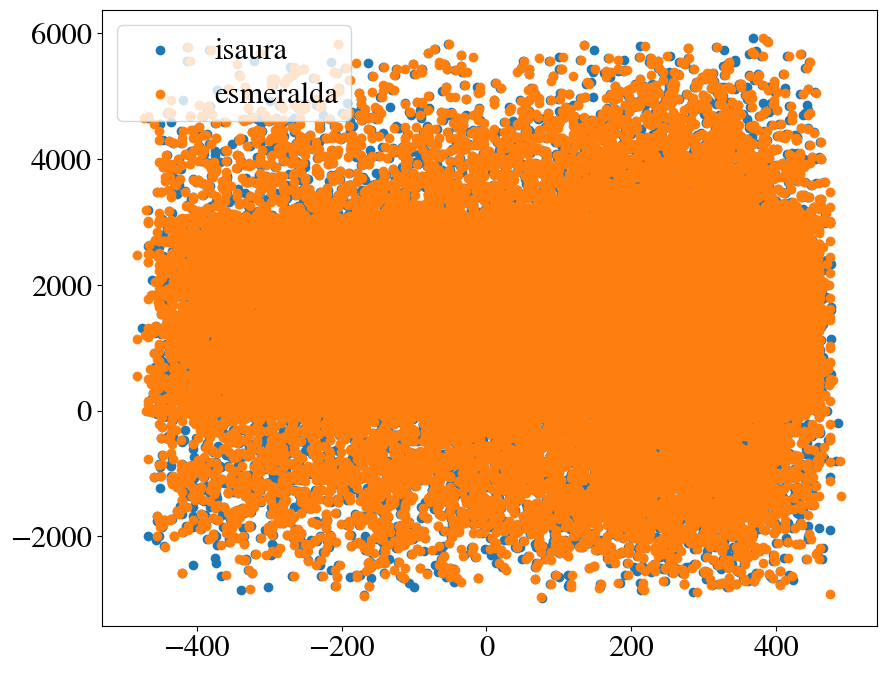

In [9]:
plt.scatter(hdst.x_ave.values, hdst.z_ave.values, label = 'isaura')
plt.scatter(esme_hdst.x_ave.values, esme_hdst.z_ave.values, label = 'esmeralda')
plt.legend()

### plot average z parameter for sophronia against isaura output

In [10]:
# validate sets
print(set(soph_hits.event.unique()) == set(esme_hdst.event.unique()))

soph_hits_filtered = soph_hits[soph_hits.event.isin(esme_hdst.event.unique())]
#display(soph_hits_filtered)
esme_hdst_filtered = esme_hdst[esme_hdst.event.isin(soph_hits_filtered.event.unique())]

print(f'Sophronia filtered hits: {soph_hits_filtered.event.nunique()}')
print(f'Esmeralda filtered dst: {esme_hdst_filtered.event.nunique()}')


print(set(soph_hits_filtered.event.unique()) == set(esme_hdst_filtered.event.unique()))

False


Sophronia filtered hits: 14824
Esmeralda filtered dst: 14824
True


In [11]:


z_diff = []
for evt, df in soph_hits_filtered.groupby('event'):
    z_diff.append(esme_hdst[esme_hdst.event == evt].z_ave.values / df.Z.mean())

In [16]:
flattened_list = np.concatenate(z_diff)
print(flattened_list)

[-3.56007954e+03  2.13643353e+00  2.02788029e+00 ...  2.16646243e+00
  2.18430081e+00  2.29631807e+00]


In [ ]:
plt.hist(flattened_list, range = (-5, 5))
plt.xlabel('ratio of esmeralda average z to sophronia z mean')

Text(0.5, 0, 'ratio of esmeralda average z to sophronia z mean')

# select 1.4 - 1.8 MeV events

In [9]:
esme_DEP_events = esme_hdst.groupby('event').energy.sum()
esme_DEP_events = esme_DEP_events[esme_DEP_events > 1.4]
esme_DEP_events = esme_DEP_events[esme_DEP_events < 1.8]
esme_DEP = esme_hdst[esme_hdst.event.isin(esme_DEP_events.index.values)]
display(esme_DEP)

isau_DEP_events = hdst.groupby('event').energy.sum()
isau_DEP_events = isau_DEP_events[isau_DEP_events > 1.4]
isau_DEP_events = isau_DEP_events[isau_DEP_events < 1.8]
isau_DEP = hdst[hdst.event.isin(isau_DEP_events.index.values)]
display(isau_DEP)

relevant_events = isau_DEP[isau_DEP.event.isin(esme_DEP.event.values)]

# sophronia
soph_DEP = soph_hits[soph_hits.event.isin(relevant_events.event.unique())]
display(soph_DEP)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
13,10642,0,0.629234,140.383701,215,425,6,243.225,-93.675,1919.827445,...,1962.236012,335.525000,-68.192183,1949.500207,0.069692,0.042004,0.000000,16.720833,16.710417,16.978728
14,10642,1,0.587834,242.114983,279,504,6,243.225,-185.975,1571.771132,...,1767.460310,366.625000,-66.567012,1573.143556,0.111076,0.043004,0.000000,16.720833,16.710417,16.978728
15,10642,2,0.092483,40.349881,7,17,6,288.875,276.525,1511.508982,...,1524.722808,304.425000,276.525000,1523.144036,0.068631,0.063494,0.039642,16.720833,16.710417,16.978728
16,10642,3,0.070824,29.105008,5,26,6,10.975,-479.925,4150.398566,...,4156.057956,24.840094,-448.825000,4168.978082,0.061804,0.060775,0.053354,16.720833,16.710417,16.978728
17,10642,4,0.019706,16.710417,2,3,6,304.425,-1.375,1417.850890,...,1422.404007,304.425000,14.175000,1425.670415,0.019706,0.019706,0.019706,16.720833,16.710417,16.978728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17609,899145,0,1.059291,242.288417,243,407,5,149.925,214.825,1707.280477,...,1753.736546,351.075000,292.075000,1733.500294,0.122791,0.045322,0.000000,16.740000,16.693056,16.960698
17610,899145,1,0.234773,52.736313,14,30,5,181.025,13.675,214.339572,...,228.419208,181.025000,13.675000,238.957474,0.123367,0.112405,0.033012,16.740000,16.693056,16.960698
17611,899145,2,0.090847,40.333819,7,18,5,335.525,-140.325,-343.639798,...,-331.783139,351.075000,-140.325000,-334.107547,0.075016,0.059833,0.045805,16.740000,16.693056,16.960698
17612,899145,3,0.026925,16.693056,2,3,5,381.175,-109.225,-170.436831,...,-162.254543,381.175000,-93.675000,-166.855796,0.026925,0.026925,0.026925,16.740000,16.693056,16.960698


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
19,5126,0,0.842861,167.304456,383,8383,12,128.625,-143.675,2739.489391,...,2870.724414,160.627277,-80.245539,2743.548573,0.096529,0.075238,0.000000,11.875000,11.964286,11.941419
20,5126,1,0.352622,64.606491,61,1375,12,-43.875,-63.675,2463.095882,...,2471.547691,-27.425496,-41.542059,2523.902104,0.141355,0.105769,0.000000,11.875000,11.964286,11.941419
21,5126,2,0.242588,386.151956,219,2611,12,-6.375,-81.175,2175.592962,...,2505.825489,16.136938,-61.161996,2175.592962,0.040265,0.014785,0.000000,11.875000,11.964286,11.941419
22,5126,3,0.147572,76.547910,60,906,12,128.625,-111.175,2558.333107,...,2635.586919,141.174716,-79.359663,2560.598640,0.056106,0.030048,0.000000,11.875000,11.964286,11.941419
23,5126,4,0.099985,28.782235,8,231,12,253.625,-48.675,1246.625580,...,1253.654669,271.088876,-42.064687,1271.929379,0.099387,0.097381,0.096783,11.875000,11.964286,11.941419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43800,2321146,4,0.028426,16.857039,2,57,6,-63.875,293.825,2116.456084,...,2120.630420,-50.528308,298.179591,2121.405849,0.028426,0.028426,0.028426,11.875000,11.964286,11.827111
43801,2321146,5,0.000893,0.000000,1,24,6,116.125,-113.675,2776.405547,...,2776.405547,121.352883,-108.058443,2776.405547,0.000893,0.000893,0.000893,11.875000,11.964286,11.827111
43885,2325549,0,1.220441,693.138321,501,7954,3,296.125,-193.675,1326.664970,...,1694.712771,351.930330,215.433577,1439.855766,0.079487,0.060526,0.000000,11.911765,11.847826,11.998373
43886,2325549,1,0.239912,76.854008,41,679,3,226.125,211.325,3370.832525,...,3443.484756,240.152755,242.595622,3372.341849,0.157028,0.017188,0.000000,11.911765,11.847826,11.998373


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
59486,716942,1.742944e+09,0,163.044519,20.110596,1,-65.775,-155.375,0.0,0.0,123.872000,7.141696,59.411991,-1.0,0.000153,-1,-1.0
59487,716942,1.742944e+09,0,163.044519,20.110596,1,10.975,369.325,0.0,0.0,123.872000,5.380126,44.757439,-1.0,0.000126,-1,-1.0
59488,716942,1.742944e+09,0,163.044519,20.110596,1,227.675,-309.875,0.0,0.0,123.872000,6.059202,50.406691,-1.0,0.000142,-1,-1.0
59489,716942,1.742944e+09,0,163.044519,20.110596,1,273.325,184.225,0.0,0.0,123.872000,6.082762,50.602684,-1.0,0.000138,-1,-1.0
59490,716942,1.742944e+09,0,163.044519,20.110596,1,474.475,-201.525,0.0,0.0,123.872000,7.383292,61.421837,-1.0,NaN,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30608049,548515,1.742942e+09,0,149.504970,25.556806,1,288.875,75.375,0.0,0.0,1279.769375,10.520014,73.670045,-1.0,0.000226,-1,-1.0
30608050,548515,1.742942e+09,0,149.504970,25.556806,1,288.875,90.925,0.0,0.0,1279.769375,11.603606,81.258277,-1.0,0.000250,-1,-1.0
30608051,548515,1.742942e+09,0,149.504970,25.556806,1,458.925,-294.825,0.0,0.0,1279.769375,5.039803,35.292965,-1.0,NaN,-1,-1.0
30608052,548515,1.742942e+09,0,149.504970,25.556806,1,490.025,-32.475,0.0,0.0,1279.769375,9.495258,66.493840,-1.0,NaN,-1,-1.0


In [10]:
print(f'Total events shared: {relevant_events.event.nunique()}')
print(f'Esmeralda events: {esme_DEP.event.nunique()}')
print(f'Isaura events: {isau_DEP.event.nunique()}')

Total events shared: 557
Esmeralda events: 557
Isaura events: 1617


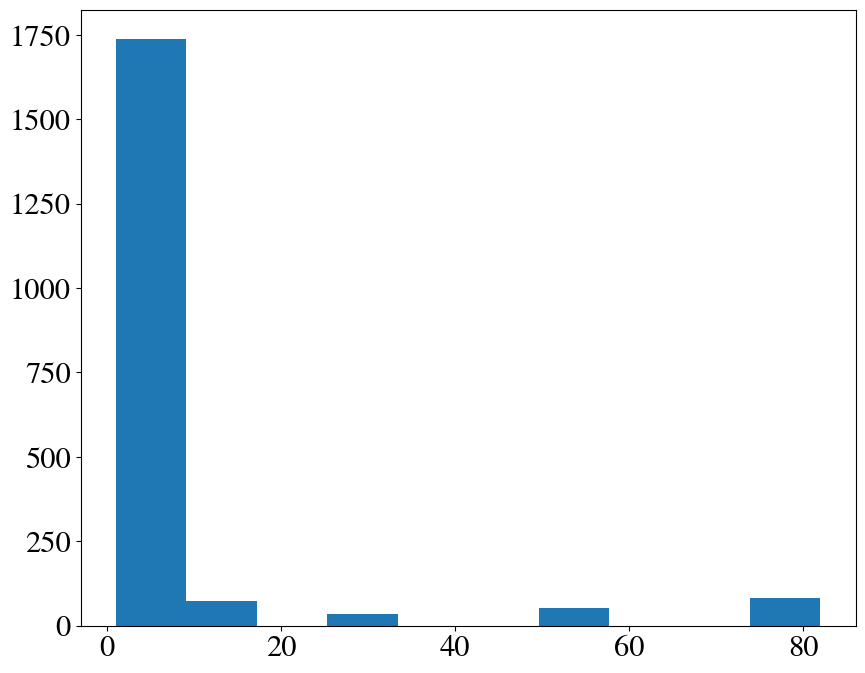

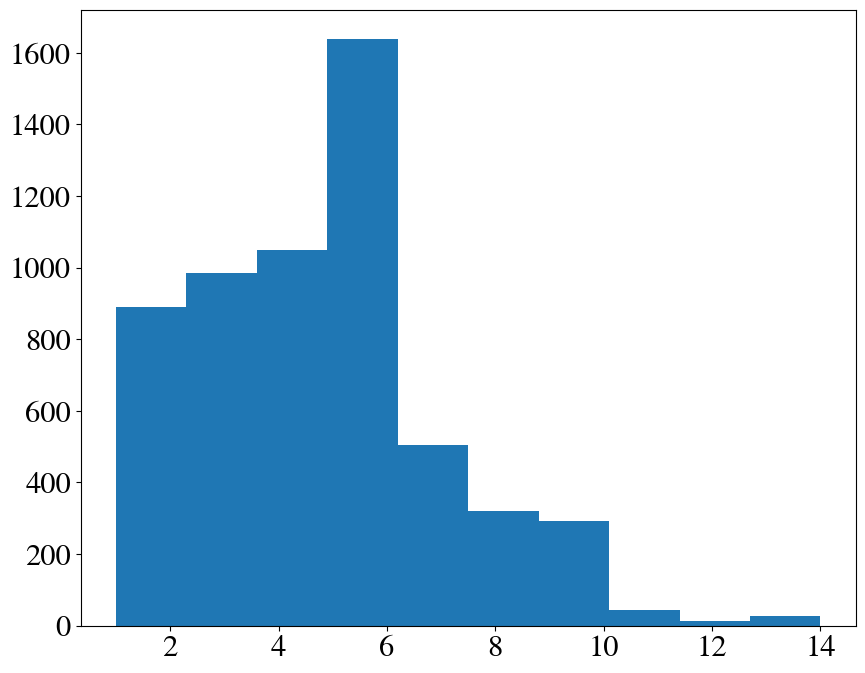

In [11]:
plt.hist(esme_DEP.numb_of_tracks.values)
plt.show()

plt.hist(isau_DEP.numb_of_tracks.values)
plt.show()

In [12]:
display(isau_DEP[isau_DEP.event == 5126])
display(esme_DEP[esme_DEP.event == 5126])

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
19,5126,0,0.842861,167.304456,383,8383,12,128.625,-143.675,2739.489391,...,2870.724414,160.627277,-80.245539,2743.548573,0.096529,0.075238,0.000000,11.875,11.964286,11.941419
20,5126,1,0.352622,64.606491,61,1375,12,-43.875,-63.675,2463.095882,...,2471.547691,-27.425496,-41.542059,2523.902104,0.141355,0.105769,0.000000,11.875,11.964286,11.941419
21,5126,2,0.242588,386.151956,219,2611,12,-6.375,-81.175,2175.592962,...,2505.825489,16.136938,-61.161996,2175.592962,0.040265,0.014785,0.000000,11.875,11.964286,11.941419
22,5126,3,0.147572,76.547910,60,906,12,128.625,-111.175,2558.333107,...,2635.586919,141.174716,-79.359663,2560.598640,0.056106,0.030048,0.000000,11.875,11.964286,11.941419
23,5126,4,0.099985,28.782235,8,231,12,253.625,-48.675,1246.625580,...,1253.654669,271.088876,-42.064687,1271.929379,0.099387,0.097381,0.096783,11.875,11.964286,11.941419
24,5126,5,0.033914,28.845312,7,146,12,16.125,-86.175,2045.046997,...,2077.805397,34.313820,-79.876384,2048.862208,0.025989,0.025851,0.017927,11.875,11.964286,11.941419
25,5126,6,0.022693,11.964286,2,42,12,218.625,-13.675,1065.645374,...,1066.378290,227.863405,0.818003,1073.273002,0.022693,0.022693,0.022693,11.875,11.964286,11.941419
26,5126,7,0.002088,0.000000,1,17,12,206.125,-36.175,1041.298110,...,1041.298110,212.816787,-31.497730,1041.298110,0.002088,0.002088,0.002088,11.875,11.964286,11.941419
27,5126,8,0.000955,16.857039,2,13,12,21.125,-68.675,2331.575569,...,2331.575569,30.778382,-64.288350,2331.575569,0.000955,0.000955,0.000955,11.875,11.964286,11.941419
28,5126,9,0.000819,0.000000,1,17,12,51.125,-83.675,2097.069480,...,2097.069480,57.800713,-78.667370,2097.069480,0.000819,0.000819,0.000819,11.875,11.964286,11.941419


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
67,5126,0,0.843330,159.588041,224,396,8,149.925,-155.375,2739.489391,...,2850.765382,149.925,-78.625000,2744.162133,0.060919,0.050334,0.000000,16.827273,16.905,16.988892
68,5126,1,0.333779,81.514764,53,98,8,-50.225,-63.075,2463.095882,...,2493.100550,-3.575,-0.166806,2491.276789,0.066990,0.050281,0.000000,16.827273,16.905,16.988892
69,5126,2,0.229160,289.309424,66,98,8,73.175,-109.725,2375.378780,...,2600.501611,73.175,-31.975000,2375.378780,0.052831,0.025380,0.000000,16.827273,16.905,16.988892
70,5126,3,0.099985,46.272993,11,19,8,257.775,-62.575,1238.165644,...,1266.654451,273.325,-32.475000,1238.165644,0.062359,0.036368,0.017501,16.827273,16.905,16.988892
71,5126,4,0.073441,70.101014,5,6,8,10.975,-63.075,2184.015642,...,2227.547734,26.525,-63.075000,2184.015642,0.039569,0.033872,0.000000,16.827273,16.905,16.988892
72,5126,5,0.073351,46.272993,9,11,8,26.525,-94.175,2045.046997,...,2045.046997,26.525,-94.175000,2088.138551,0.032870,0.032308,0.000000,16.827273,16.905,16.988892
73,5126,6,0.068738,47.823825,9,14,8,26.525,-47.525,2288.643912,...,2322.878233,26.525,-47.525000,2291.256314,0.039030,0.030188,0.002290,16.827273,16.905,16.988892
74,5126,7,0.024781,16.905000,2,2,8,227.675,-16.425,1065.645374,...,1065.645374,227.675,-0.875000,1074.120810,0.024781,0.024781,0.024781,16.827273,16.905,16.988892


In [32]:
track_diff = []

for evt, df in isau_DEP.groupby('event'):
    # if the event is in the esmeralda data also
    if evt in esme_DEP.event.unique():
        track_diff.append(esme_DEP[esme_DEP.event == evt].numb_of_tracks.unique() - df.numb_of_tracks.unique())

print(track_diff)

[array([1]), array([-4]), array([1]), array([1]), array([0]), array([-1]), array([-1]), array([0]), array([0]), array([2]), array([-1]), array([0]), array([-1]), array([-7]), array([1]), array([7]), array([0]), array([0]), array([-1]), array([0]), array([-1]), array([-1]), array([-1]), array([0]), array([0]), array([0]), array([-3]), array([0]), array([-1]), array([-2]), array([-2]), array([-2]), array([-1]), array([3]), array([-2]), array([-1]), array([1]), array([-2]), array([0]), array([0]), array([-1]), array([-1]), array([-1]), array([0]), array([1]), array([0]), array([0]), array([-1]), array([-1]), array([0]), array([0]), array([1]), array([0]), array([0]), array([0]), array([0]), array([-1]), array([0]), array([1]), array([0]), array([-1]), array([0]), array([-1]), array([0]), array([2]), array([-1]), array([0]), array([0]), array([0]), array([0]), array([-2]), array([0]), array([0]), array([1]), array([-2]), array([2]), array([0]), array([-1]), array([0]), array([-1]), array([

In [37]:
print(track_diff[1][0])

track_diff = [x[0] for x in track_diff]
print(track_diff)

-4
[1, -4, 1, 1, 0, -1, -1, 0, 0, 2, -1, 0, -1, -7, 1, 7, 0, 0, -1, 0, -1, -1, -1, 0, 0, 0, -3, 0, -1, -2, -2, -2, -1, 3, -2, -1, 1, -2, 0, 0, -1, -1, -1, 0, 1, 0, 0, -1, -1, 0, 0, 1, 0, 0, 0, 0, -1, 0, 1, 0, -1, 0, -1, 0, 2, -1, 0, 0, 0, 0, -2, 0, 0, 1, -2, 2, 0, -1, 0, -1, 0, 0, 2, 0, 0, 1, 0, 1, -1, 0, -1, 0, -1, 1, -1, -1, 0, 0, 0, 1, -1, -1, -3, 1, 0, 2, -1, -1, 2, 0, 1, 0, 0, -1, 1, 0, -1, 0, 1, -1, 0, 0, 1, -2, -1, 2, 0, -5, 1, 0, 0, -1, 3, 0, 0, -1, 0, 0, 2, -2, -4, 0, 0, 0, 0, 0, -1, 0, 0, 0, -1, 0, 0, -1, -1, 0, -1, -2, -1, 1, -1, 1, 0, 0, 0, 0, 1, -1, -3, 0, -4, -1, -3, 0, -1, 1, -1, 0, -1, -1, 2, -3, 3, 4, -1, -4, -1, 0, 0, -1, -1, 2, -1, -2, -1, 0, 0, -1, 0, -2, 1, -1, 0, 0, -1, -2, -1, 1, 0, -1, 1, -1, 2, 0, 0, 1, 0, 0, 0, 0, -2, -1, -1, 0, 0, -1, -1, -1, 0, 0, 0, -1, 0, 0, -1, -1, 0, -4, -1, 0, 0, 0, -1, 0, 1, 1, -1, 0, -1, 1, 0, -1, -1, -1, 3, -3, 1, 0, 0, 5, 1, 0, 1, 0, 0, 0, -4, -1, 0, 0, -1, -2, 0, -1, 0, -2, -2, 0, -1, 1, -1, 0, -1, -2, -1, -1, 0, -2, 1, 1, 1, 0, -2

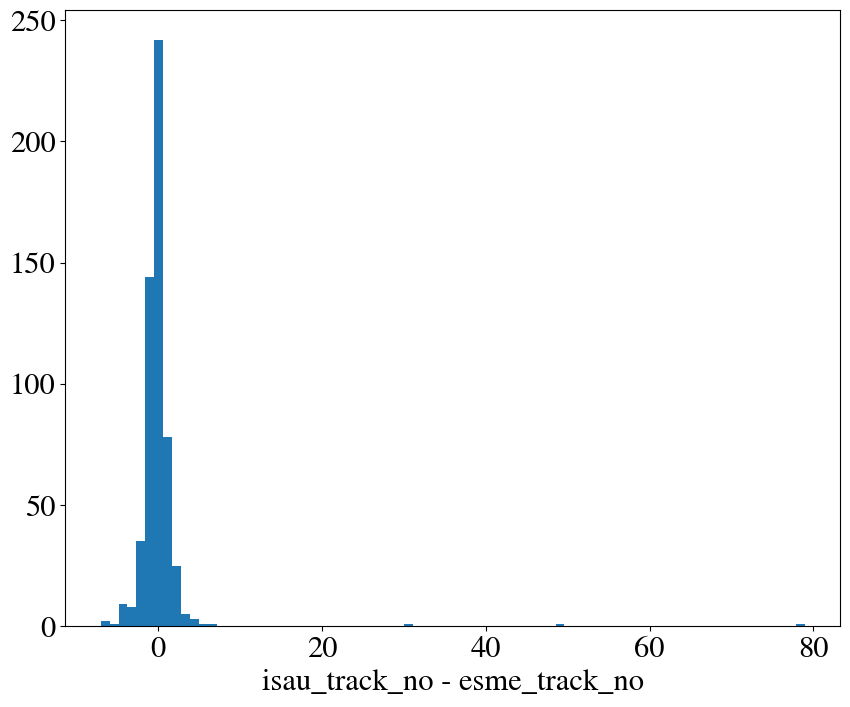

In [39]:
plt.hist(track_diff, bins = max(track_diff))
plt.xlabel('isau_track_no - esme_track_no')
plt.show()

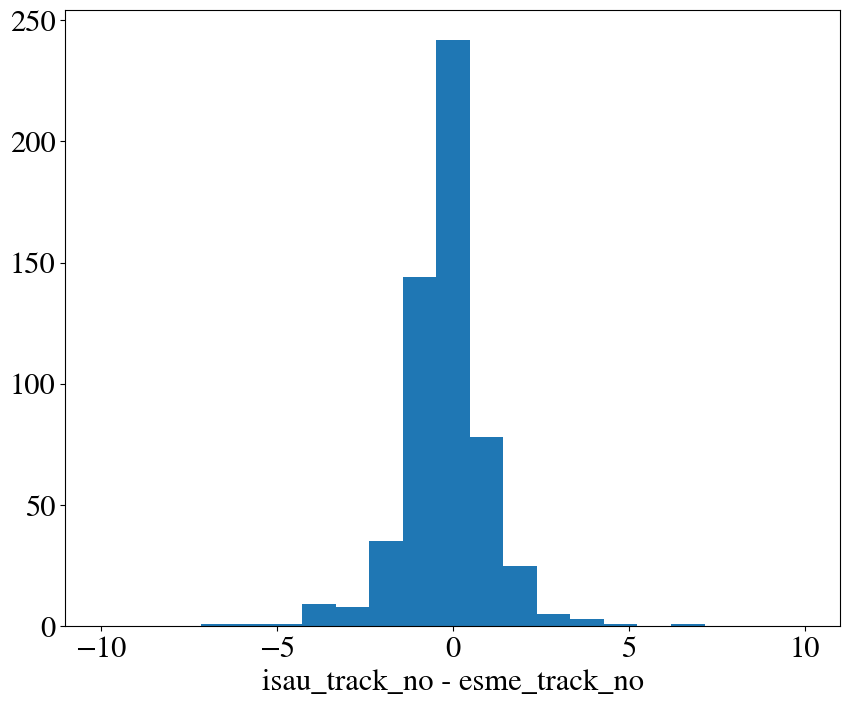

In [41]:
plt.hist(track_diff, bins = 21, range = (-10, 10))
plt.xlabel('isau_track_no - esme_track_no')
plt.show()

In [ ]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = esme_DEP.energy
track_no = esme_DEP.numb_of_tracks
# normalise
print(f'Maximal number of tracks: {track_no}')
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001, range = ((0,0.5),(-0.5,20)))
plt.title(f"Track energies: ESME R{RUN_NUMBER}")
plt.colorbar()
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.show()

Maximal number of tracks: 13       6
14       6
15       6
16       6
17       6
        ..
17609    5
17610    5
17611    5
17612    5
17613    5
Name: numb_of_tracks, Length: 1977, dtype: int64


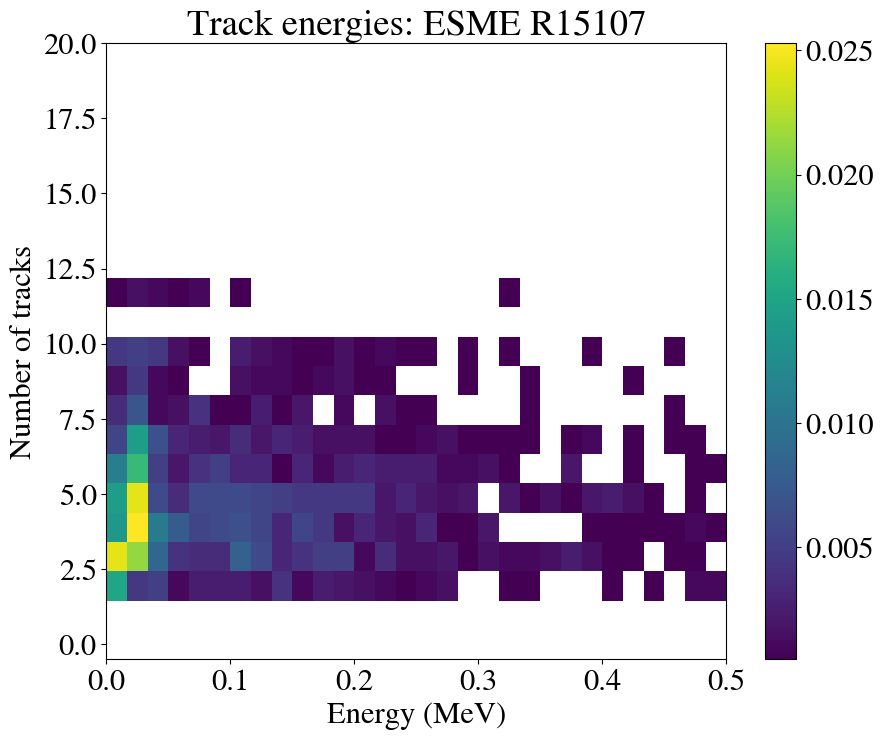

In [42]:
# useful to normalize histograms
def get_weights(data, norm):
    if norm:
        return np.repeat(1.0/len(data), len(data))
    else:
        return np.repeat(1.0, len(data))

track_energy = esme_DEP.energy
track_no = esme_DEP.numb_of_tracks
# normalise
print(f'Maximal number of tracks: {track_no}')
weights = get_weights(track_energy, True)
#plt.hist2d(track_energy, track_no, bins=(50, 20), cmin=0.001)
plt.hist2d(track_energy, track_no, weights = weights, bins=(30, 21), cmin=0.0001, range = ((0,0.5),(-0.5,20)))
plt.title(f"Track energies: ESME R{RUN_NUMBER}")
plt.colorbar()
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of tracks')
plt.show()

# plot event with low energy

In [47]:
low_E_evts = []

for evt, df in esme_DEP.groupby('event'):
    if np.any(df.energy < 0.05):
        low_E_evts.append(evt)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
13,10642,0,0.629234,140.383701,215,425,6,243.225,-93.675,1919.827445,...,1962.236012,335.525000,-68.192183,1949.500207,0.069692,0.042004,0.000000,16.720833,16.710417,16.978728
14,10642,1,0.587834,242.114983,279,504,6,243.225,-185.975,1571.771132,...,1767.460310,366.625000,-66.567012,1573.143556,0.111076,0.043004,0.000000,16.720833,16.710417,16.978728
15,10642,2,0.092483,40.349881,7,17,6,288.875,276.525,1511.508982,...,1524.722808,304.425000,276.525000,1523.144036,0.068631,0.063494,0.039642,16.720833,16.710417,16.978728
16,10642,3,0.070824,29.105008,5,26,6,10.975,-479.925,4150.398566,...,4156.057956,24.840094,-448.825000,4168.978082,0.061804,0.060775,0.053354,16.720833,16.710417,16.978728
17,10642,4,0.019706,16.710417,2,3,6,304.425,-1.375,1417.850890,...,1422.404007,304.425000,14.175000,1425.670415,0.019706,0.019706,0.019706,16.720833,16.710417,16.978728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17609,899145,0,1.059291,242.288417,243,407,5,149.925,214.825,1707.280477,...,1753.736546,351.075000,292.075000,1733.500294,0.122791,0.045322,0.000000,16.740000,16.693056,16.960698
17610,899145,1,0.234773,52.736313,14,30,5,181.025,13.675,214.339572,...,228.419208,181.025000,13.675000,238.957474,0.123367,0.112405,0.033012,16.740000,16.693056,16.960698
17611,899145,2,0.090847,40.333819,7,18,5,335.525,-140.325,-343.639798,...,-331.783139,351.075000,-140.325000,-334.107547,0.075016,0.059833,0.045805,16.740000,16.693056,16.960698
17612,899145,3,0.026925,16.693056,2,3,5,381.175,-109.225,-170.436831,...,-162.254543,381.175000,-93.675000,-166.855796,0.026925,0.026925,0.026925,16.740000,16.693056,16.960698


In [60]:
# lets apply our own cut
q_cut = 15
cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
hits_cut = coref.timefunc(cut_sensors)(soph_DEP.copy())




Time spent in cut_over_Q: 13.761598348617554 s


EVENT 1962
Total energy 0.88 MeV



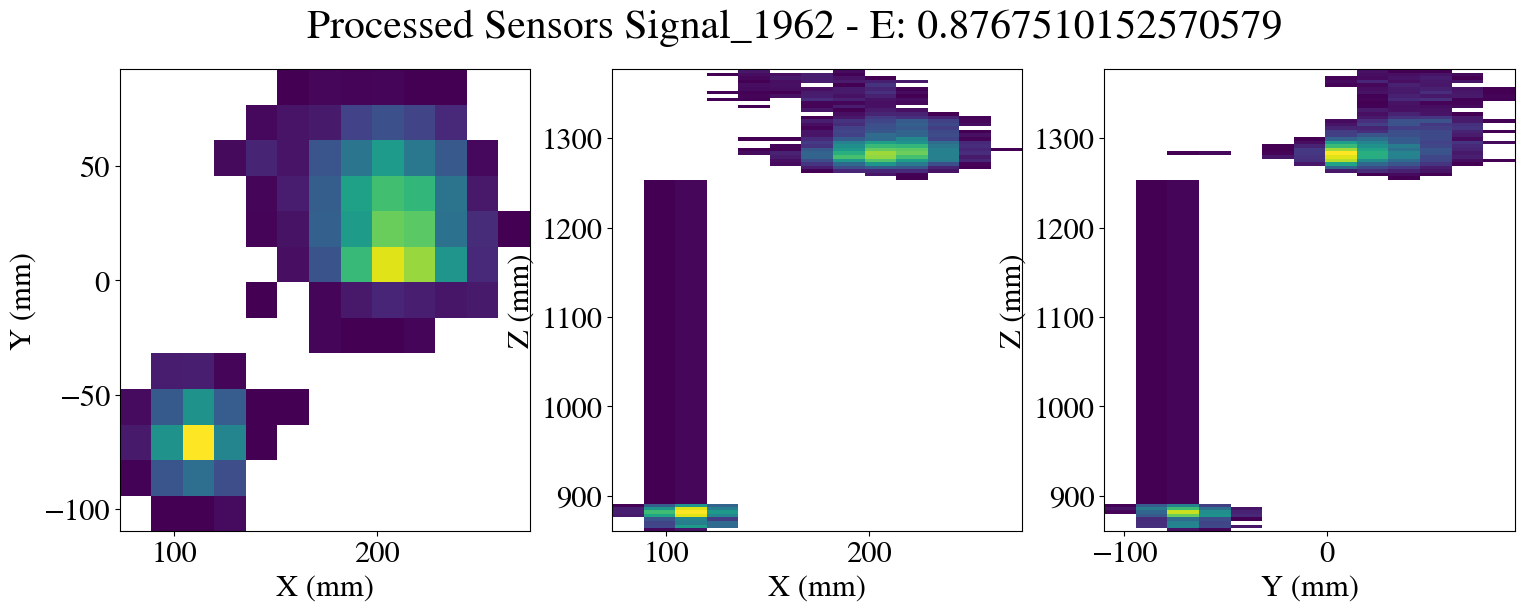

EVENT 5126
Total energy 1.00 MeV



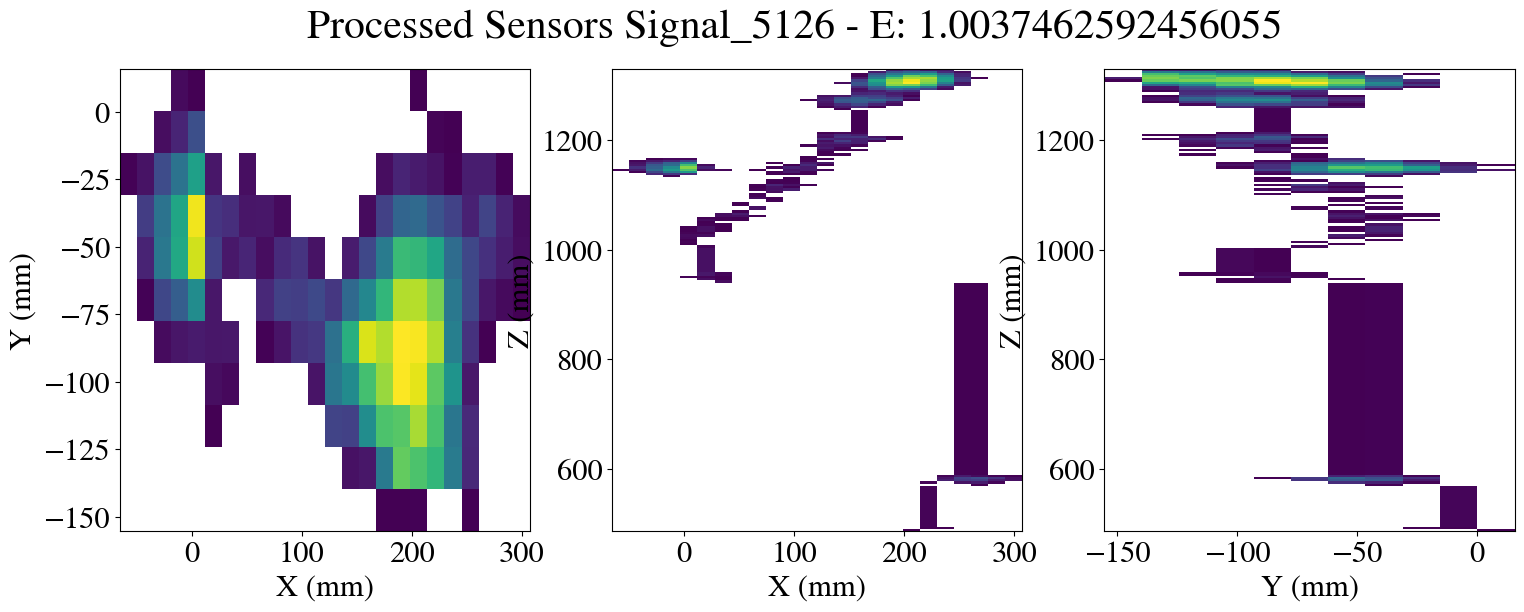

EVENT 6134
Total energy 0.84 MeV



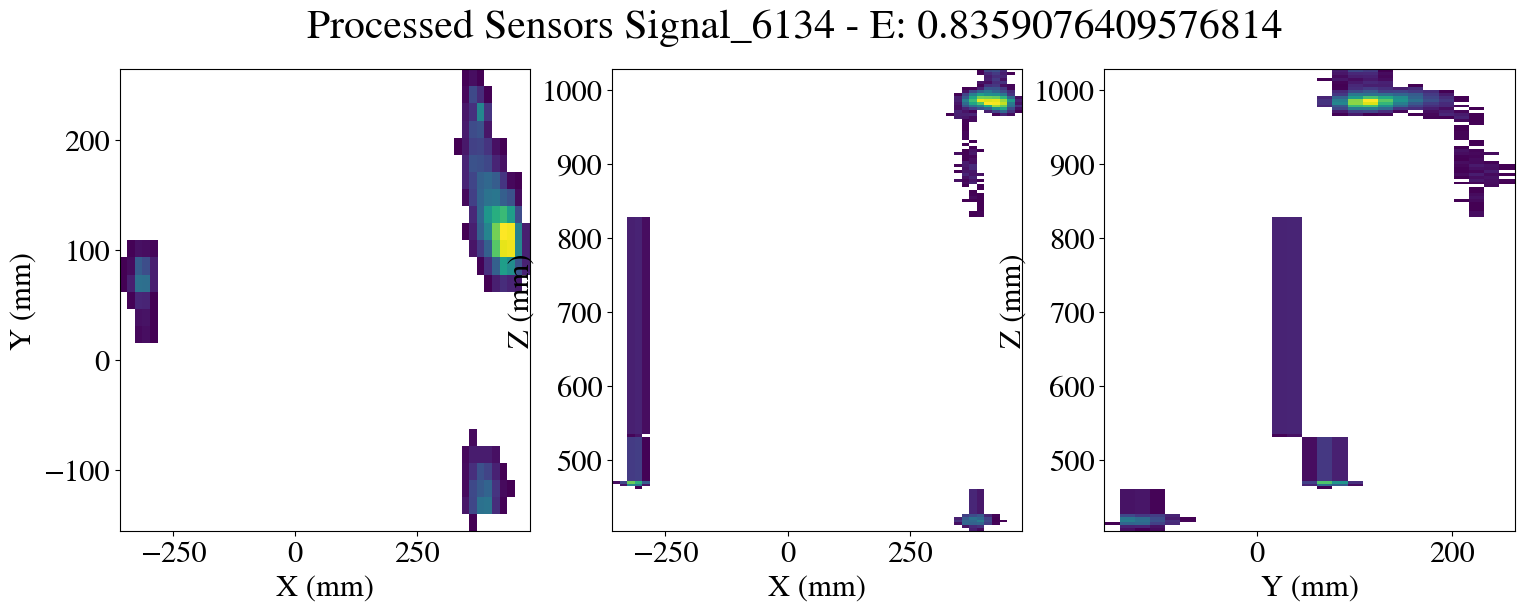

EVENT 6211
Total energy 1.02 MeV



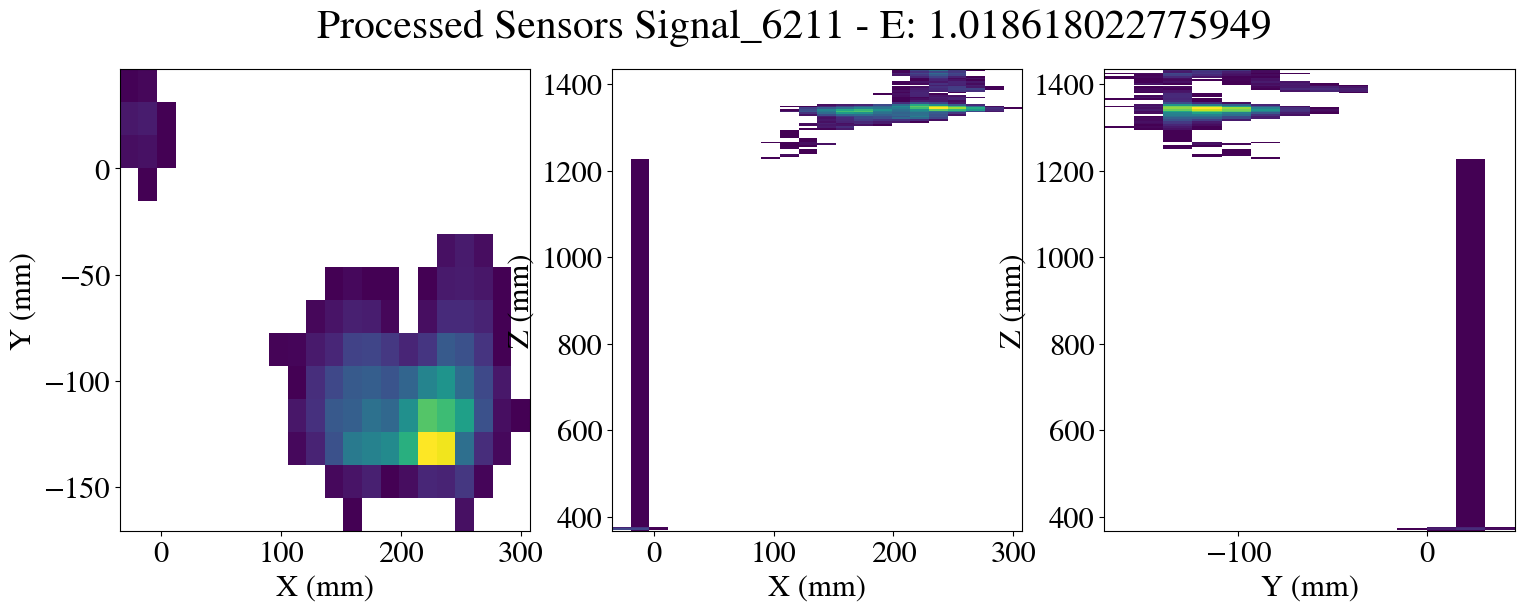

EVENT 10642
Total energy 0.81 MeV



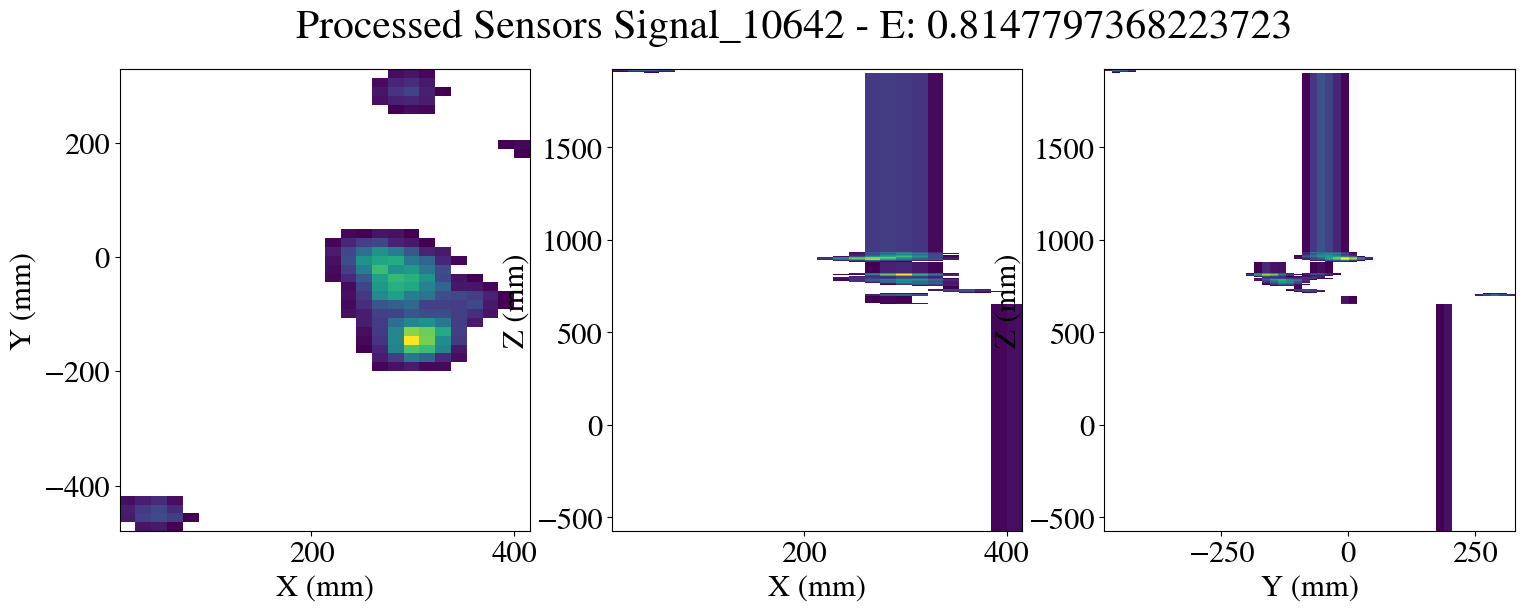

EVENT 11825
Total energy 0.94 MeV



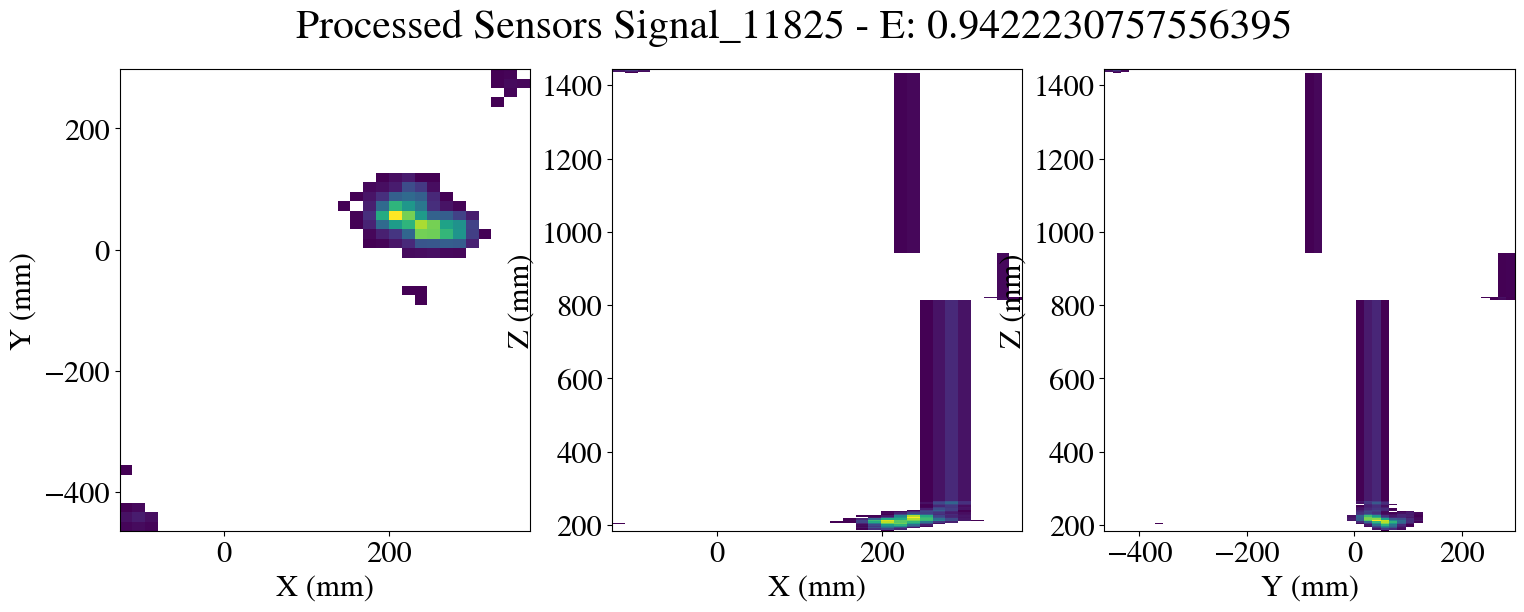

EVENT 12133
Total energy 0.86 MeV



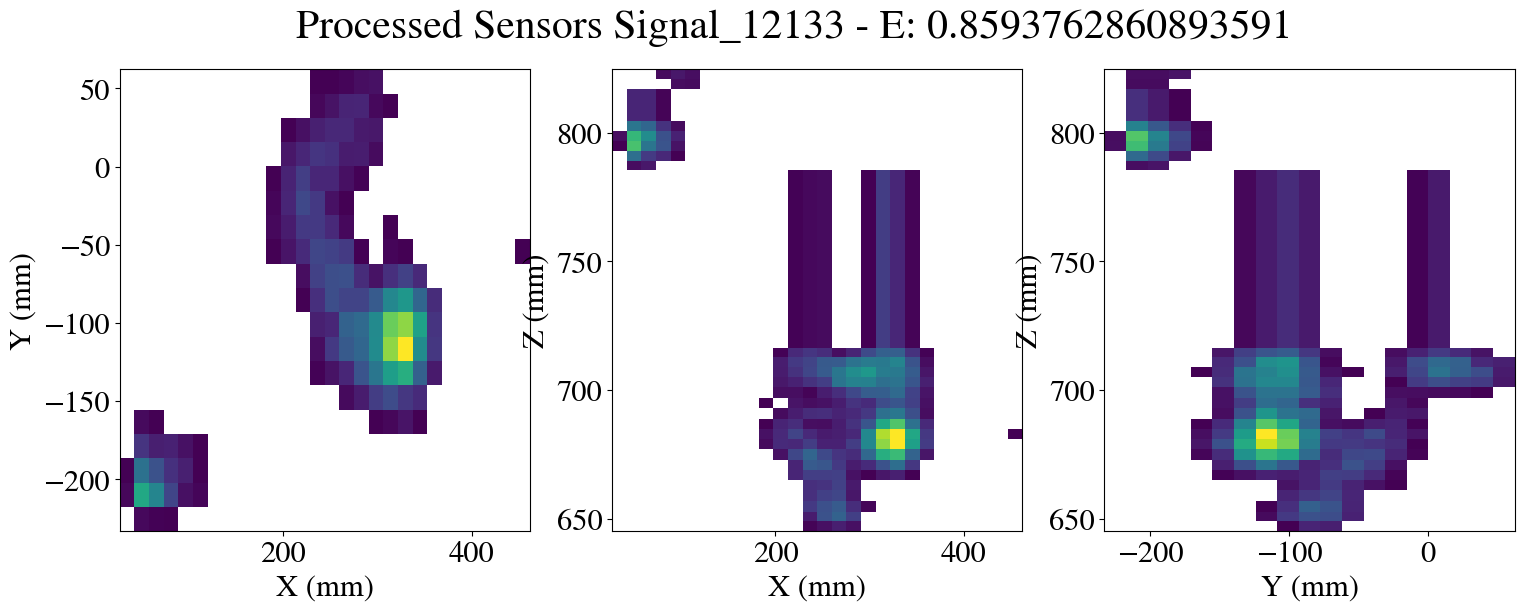

EVENT 14597
Total energy 0.85 MeV



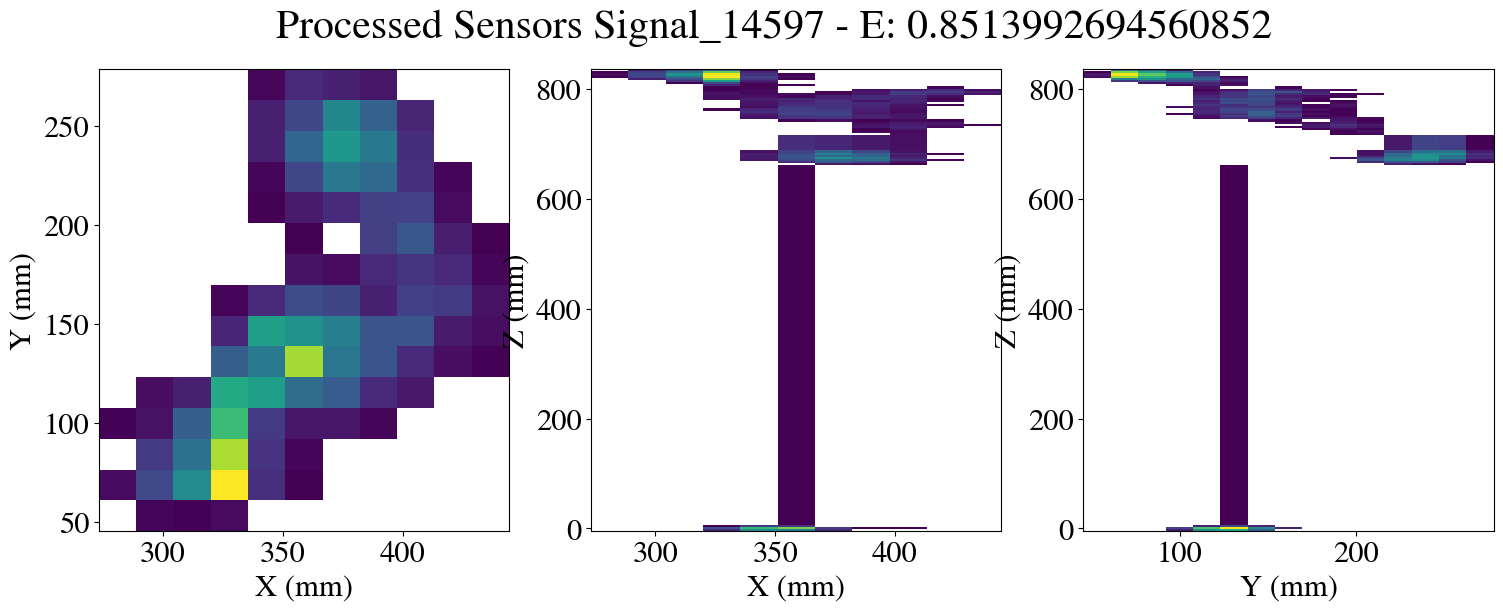

EVENT 25048
Total energy 0.89 MeV



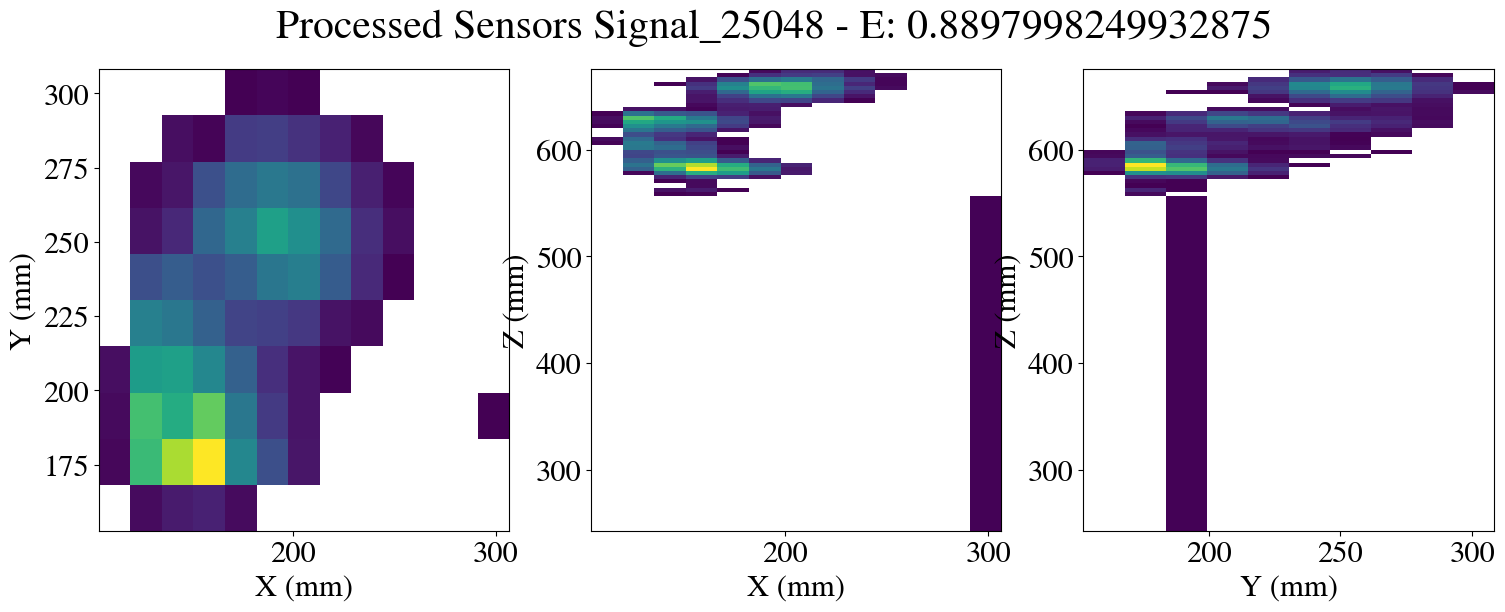

EVENT 32139
Total energy 0.93 MeV



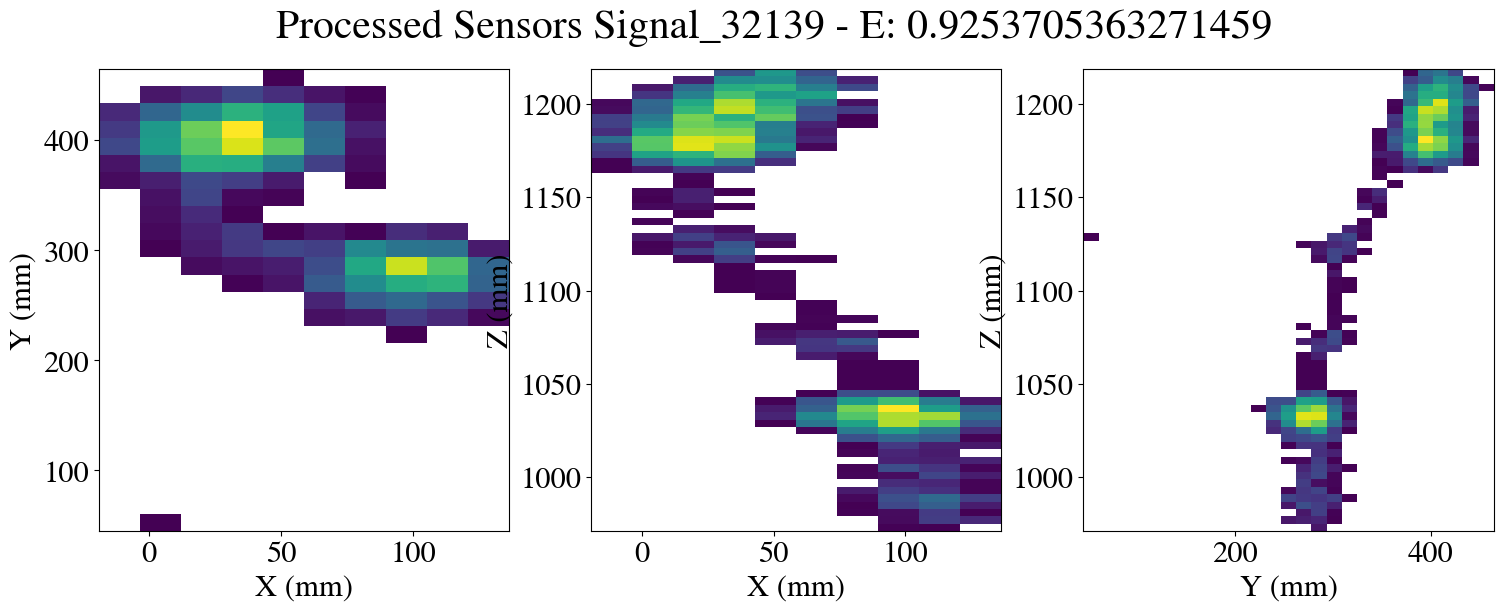

EVENT 37907
Total energy 0.96 MeV



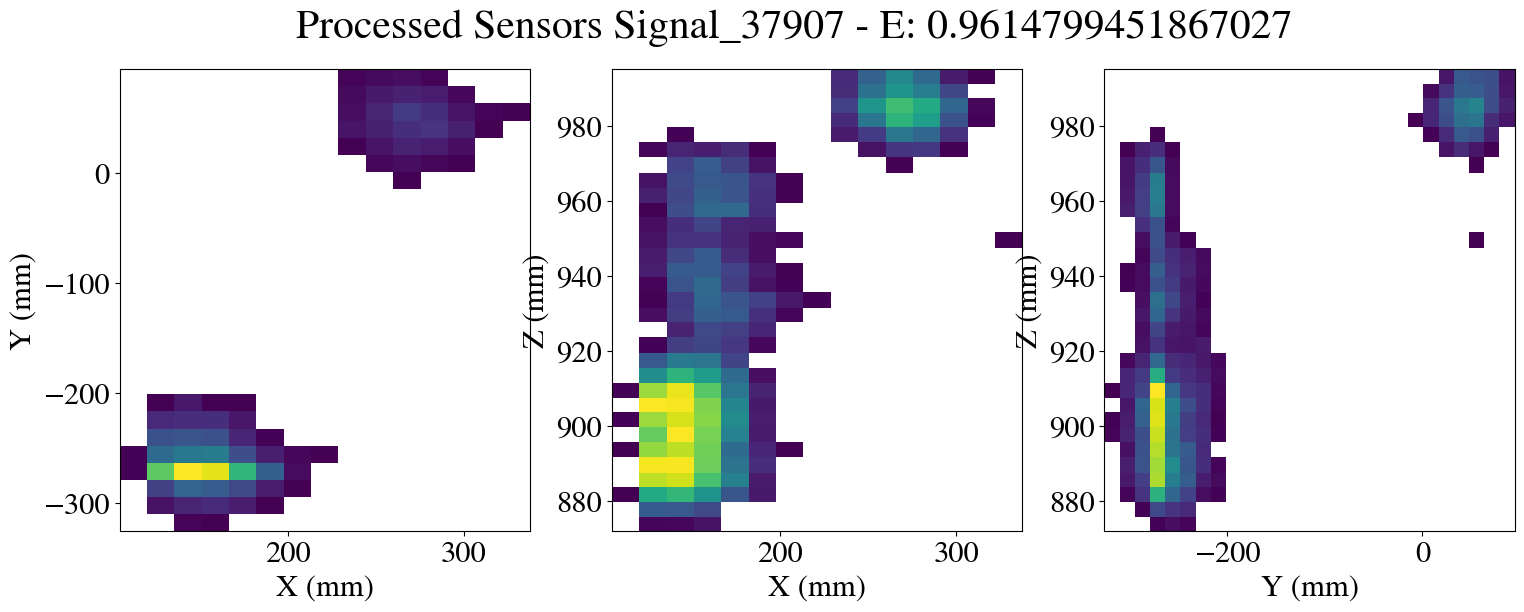

EVENT 39461
Total energy 0.91 MeV



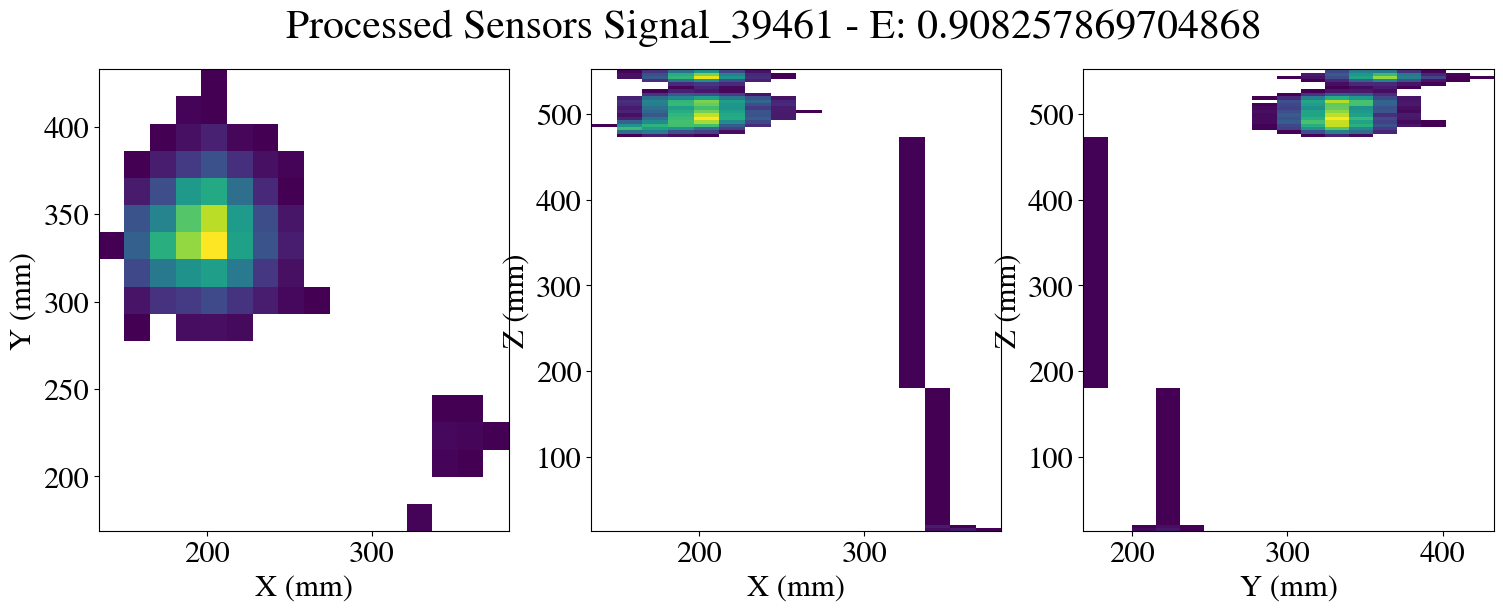

EVENT 45243
Total energy 0.93 MeV



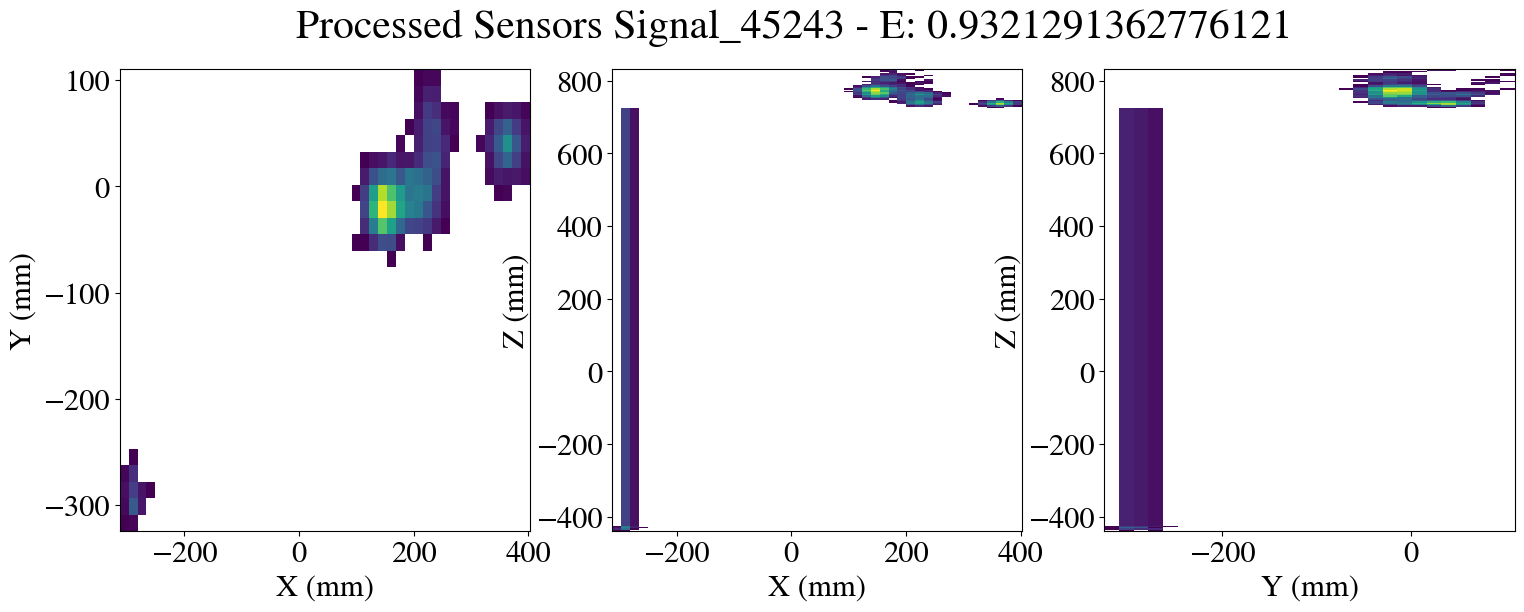

EVENT 47672
Total energy 0.92 MeV



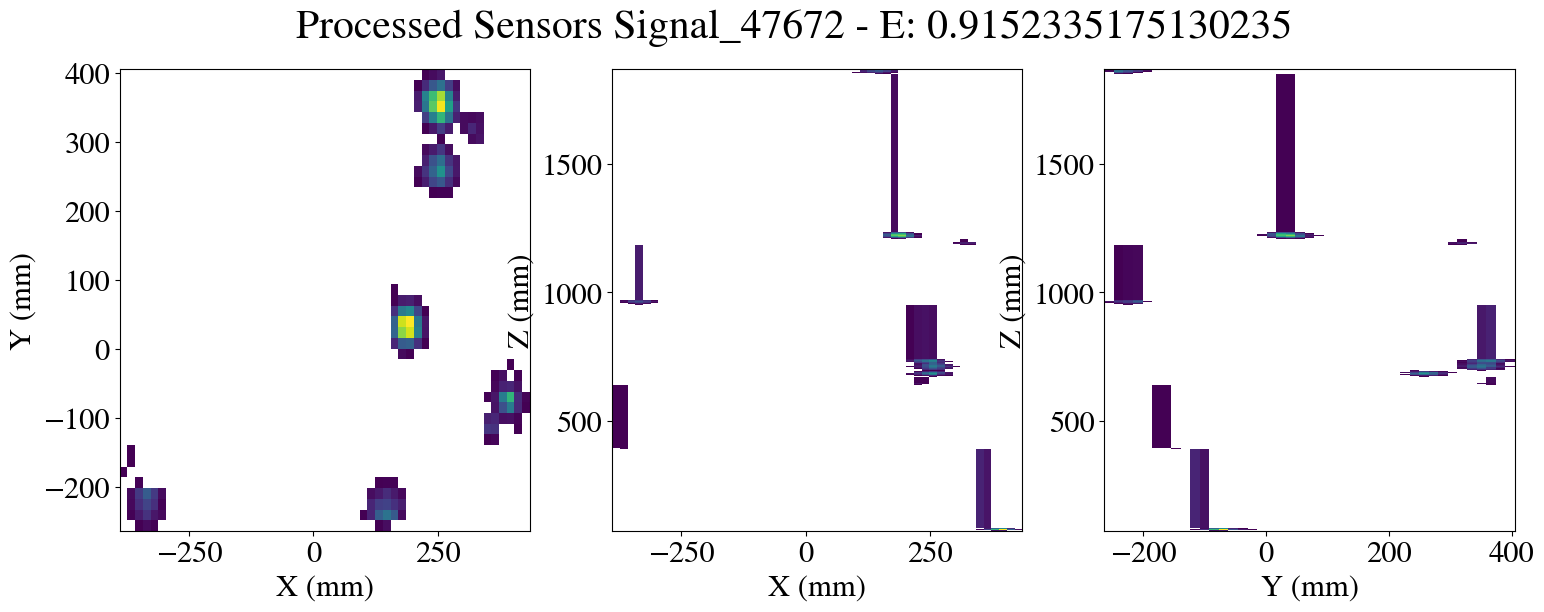

EVENT 48288
Total energy 0.86 MeV



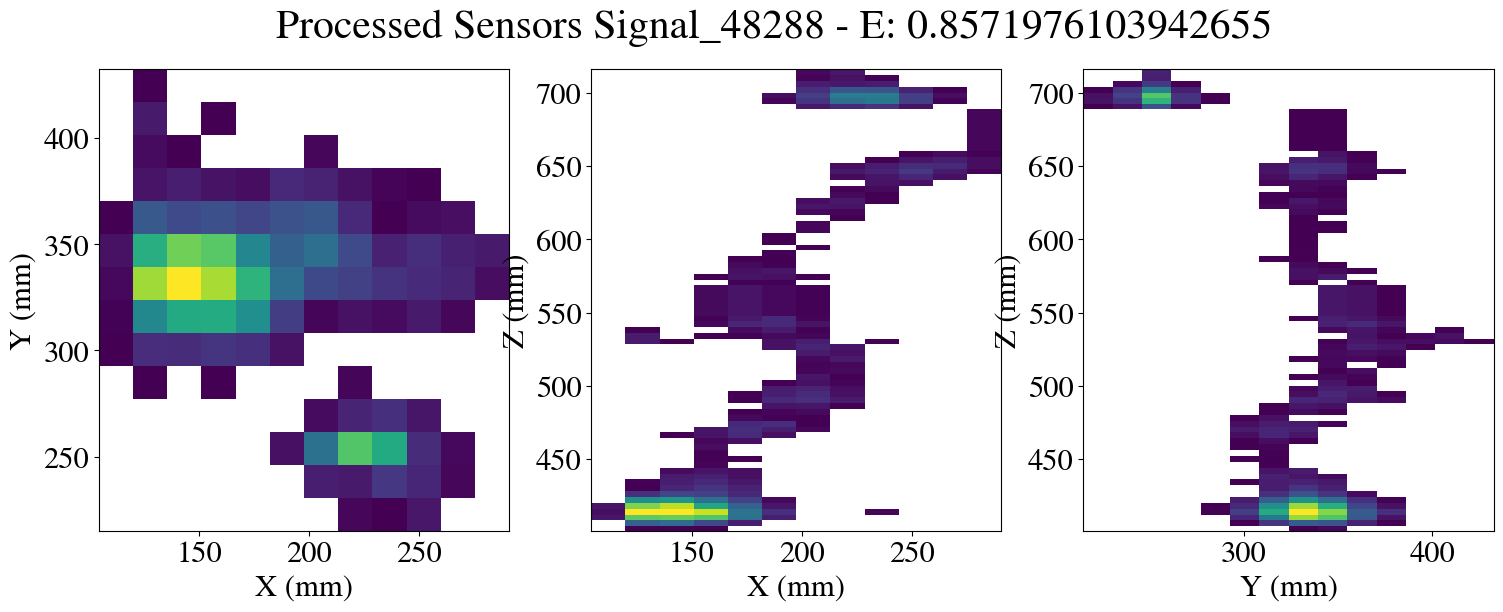

EVENT 51683
Total energy 0.85 MeV



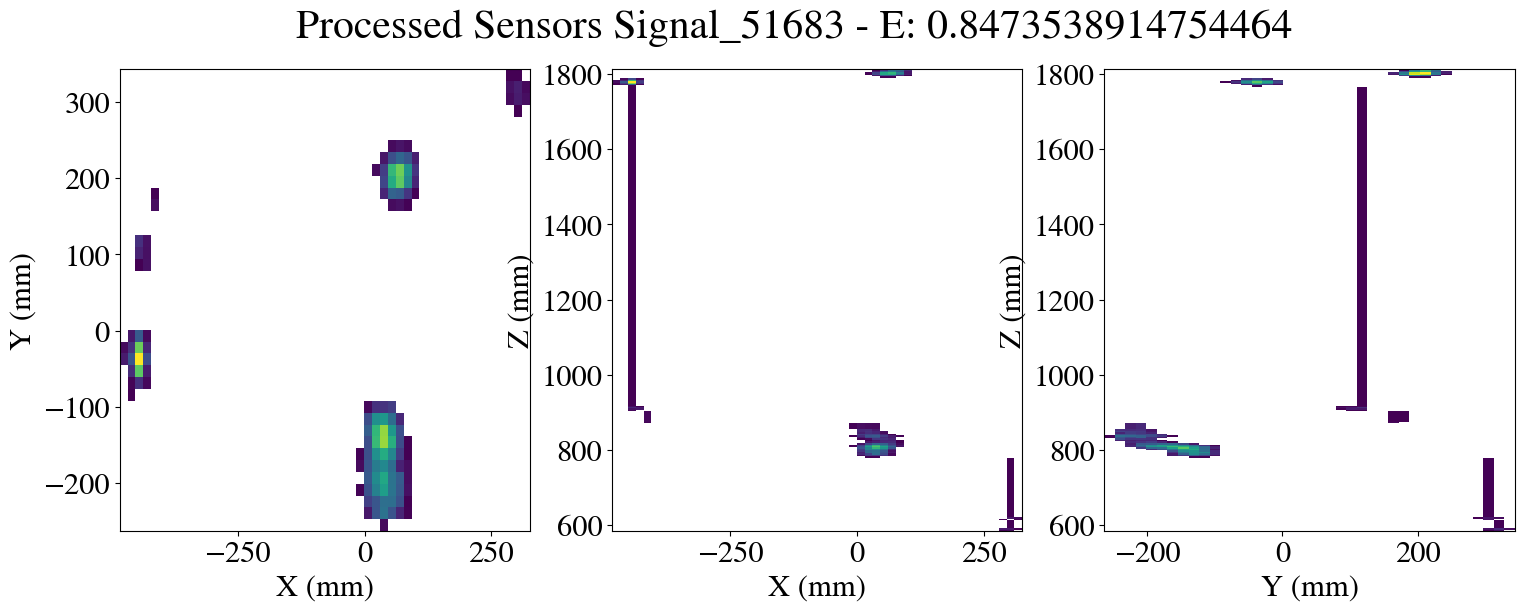

EVENT 53916
Total energy 0.76 MeV



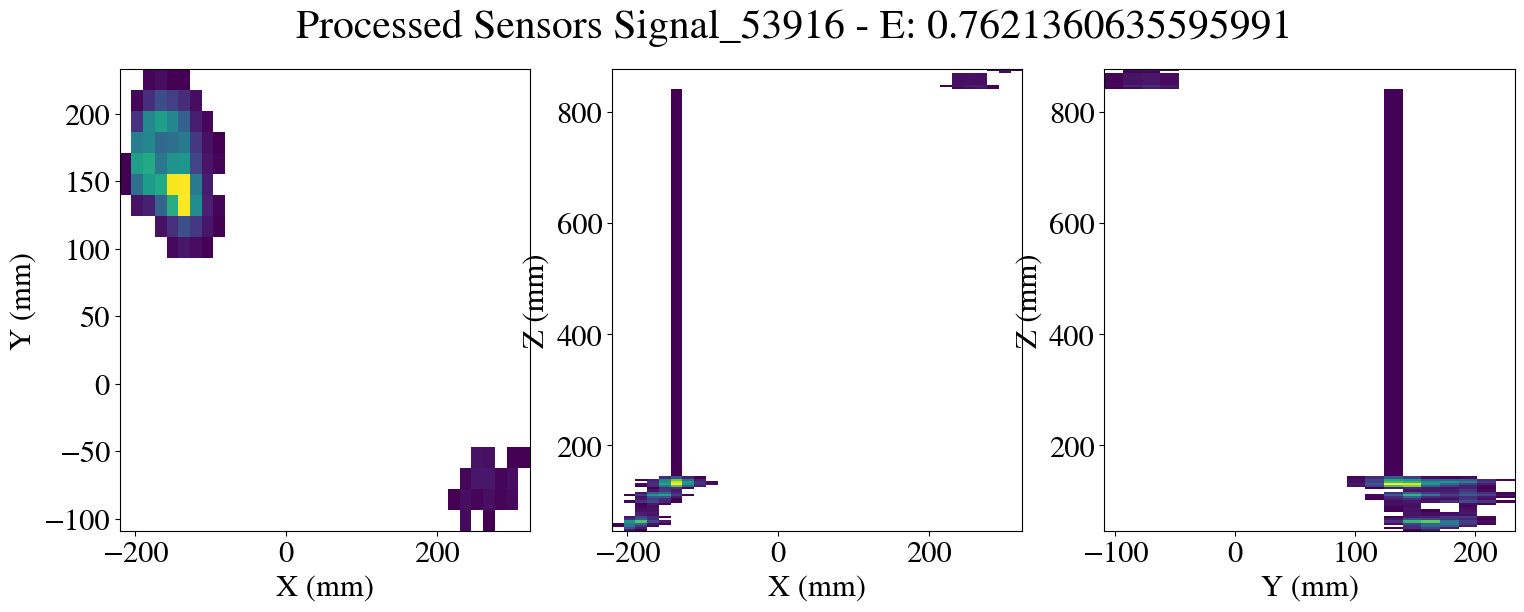

EVENT 57045
Total energy 0.89 MeV



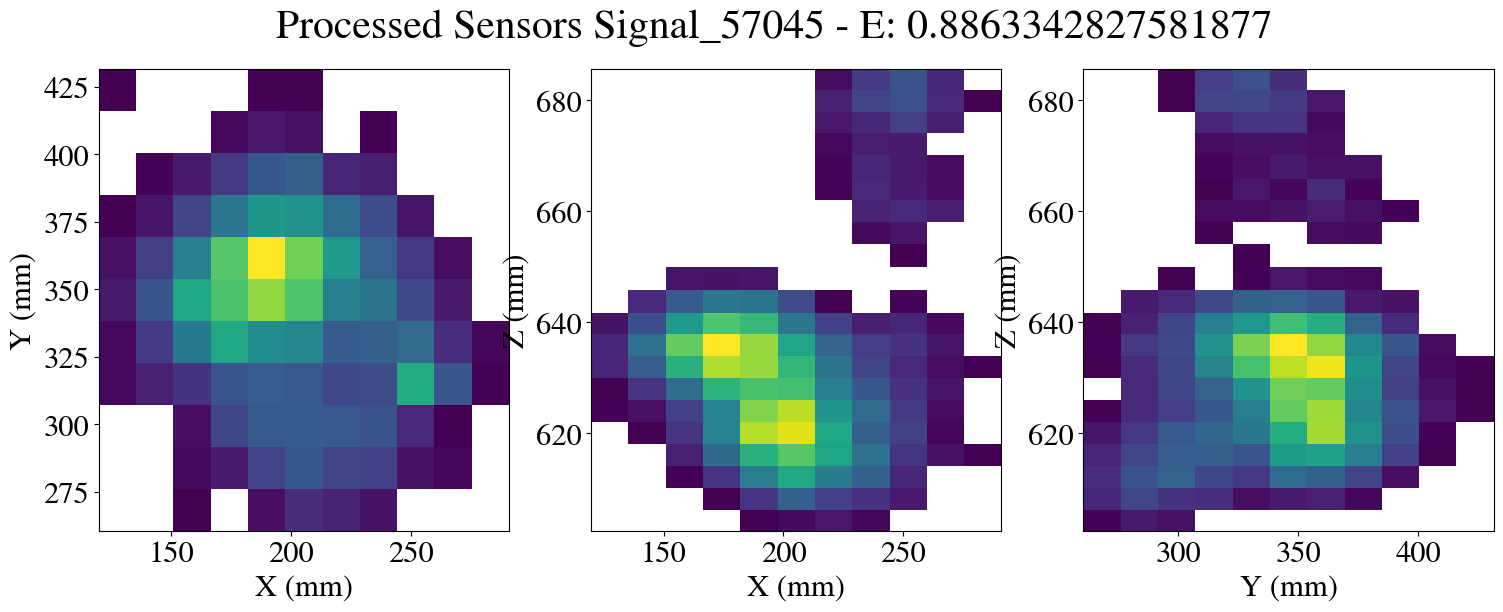

EVENT 57458
Total energy 0.86 MeV



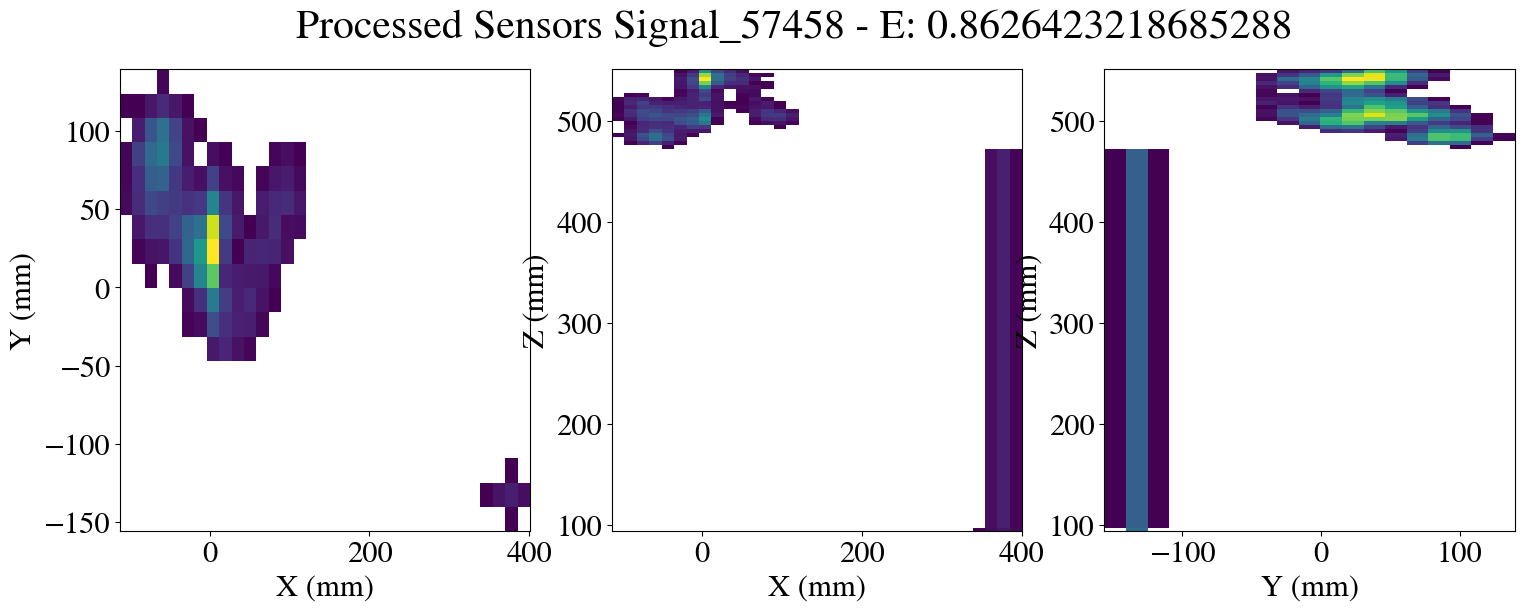

EVENT 58851
Total energy 0.84 MeV



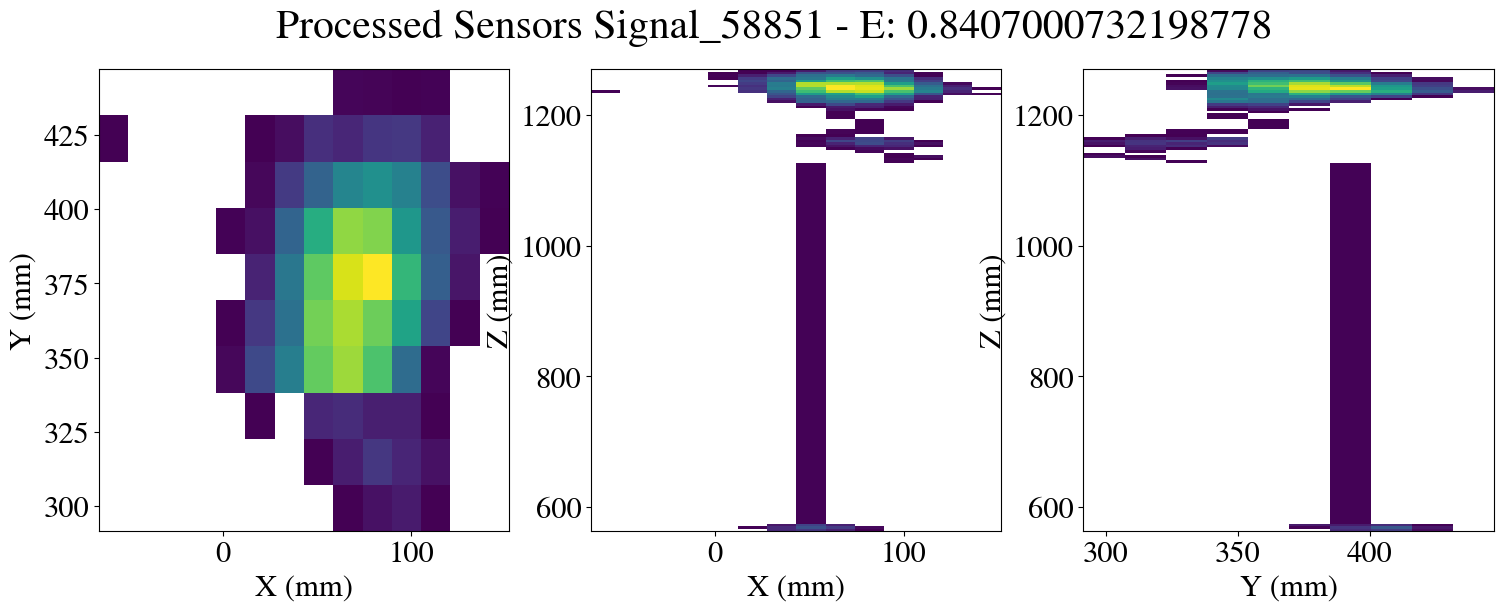

EVENT 60615
Total energy 0.90 MeV



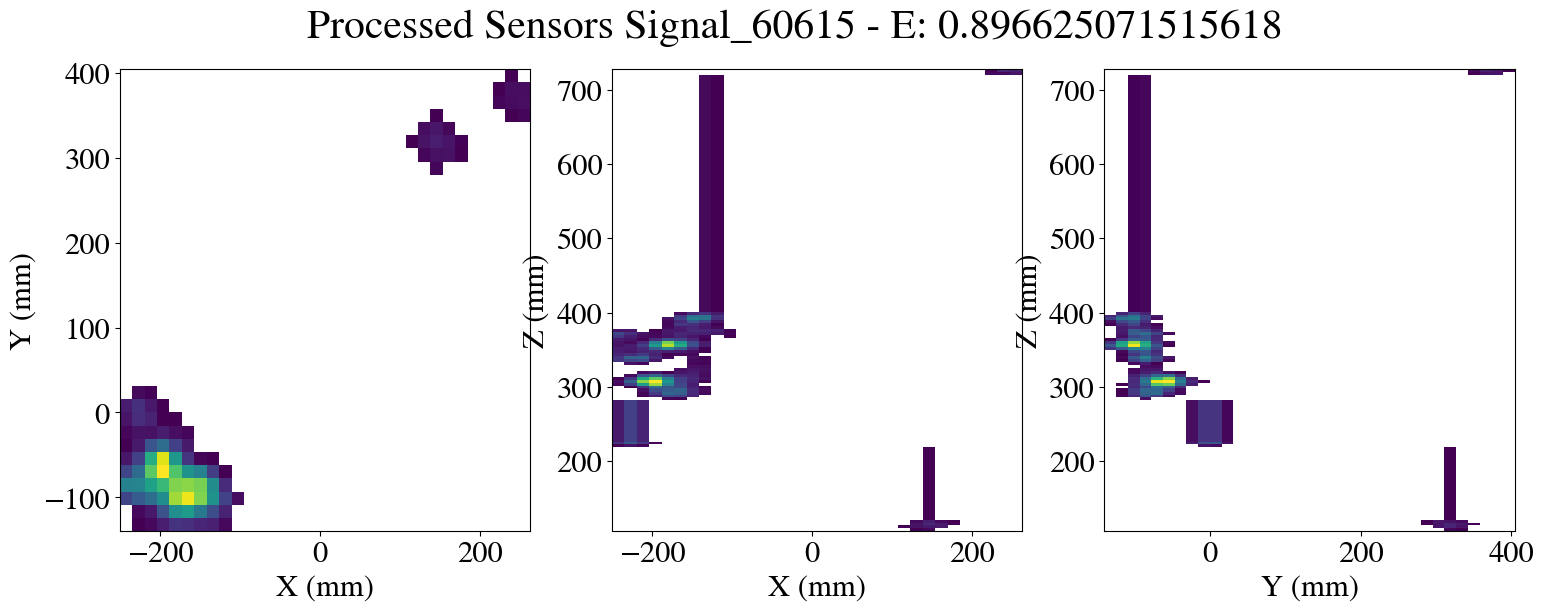

EVENT 61861
Total energy 0.91 MeV



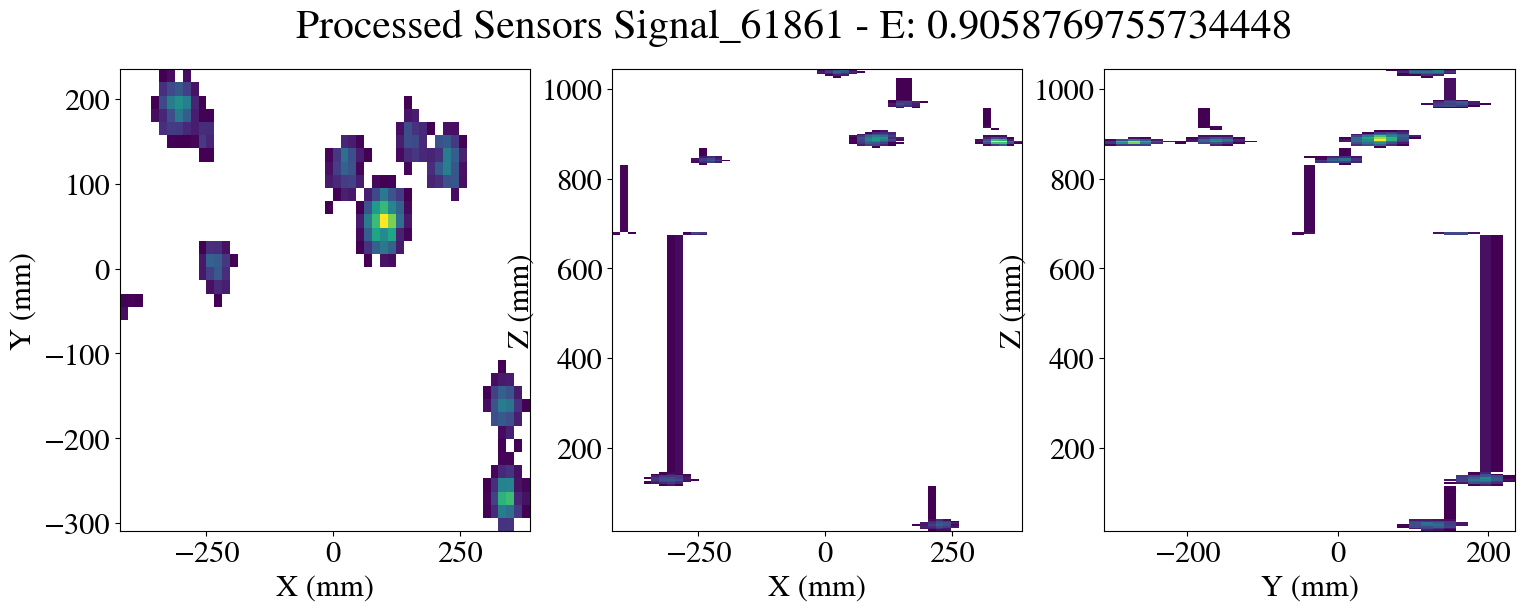

In [61]:
stopper = 20
for i, evt in enumerate(low_E_evts):
    func.plotter(hits_cut, evt, cut_n_drop = False)

    if i > stopper:
        break

In [ ]:
display(isau_DEP.groupby('event').numb_of_tracks.unique() - esme_DEP.groupby('event').numb_of_tracks.unique())
display(isau_DEP.groupby('event').numb_of_tracks.unique())
display(esme_DEP.groupby('event').numb_of_tracks.unique())

event
1962        [-1]
5126         [4]
6134        [-1]
6211        [-1]
6869         [0]
           ...  
2320292    [nan]
2320824    [nan]
2321146    [nan]
2323575    [nan]
2325549    [nan]
Name: numb_of_tracks, Length: 1617, dtype: object

event
1962        [2]
5126       [12]
6134        [4]
6211        [2]
6869        [1]
           ... 
2320292     [1]
2320824     [3]
2321146     [6]
2323575     [3]
2325549     [3]
Name: numb_of_tracks, Length: 1617, dtype: object

event
1962      [3]
5126      [8]
6134      [5]
6211      [3]
6869      [1]
         ... 
898487    [6]
899145    [5]
904297    [3]
906061    [6]
913068    [1]
Name: numb_of_tracks, Length: 557, dtype: object